# Major Project : Womens Clothing E-Commerce Review

# Analysis:

## (1)Describe the data
### &emsp; &emsp; &emsp; Descriptive statistics, data type, etc.
## (2)Analyze the text comment/ review and share the findings
## (3)Convert the ratings into 2 classes
### &emsp; &emsp; &emsp; Class: Bad when Rating $<=$ 3
### &emsp; &emsp; &emsp; Class: Good otherwise
## (4)Develop a model to predict the Rating class (created above)
### &emsp; &emsp; &emsp; Focus on steps to build a model
### &emsp; &emsp; &emsp; Which algorithm can be used and why
## (5)Share the findings of the model.

## Data Description

### This dataset includes 23486 rows and 10 feature variables. Each row corresponds to a customer review, and includes the variables:

#### Clothing ID: Integer Categorical variable that refers to the specific piece being reviewed.
#### Age: Positive Integer variable of the reviewers age.
#### Title: String variable for the title of the review.
#### Review Text: String variable for the review body.
#### Rating: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.
#### Recommended IND: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.
#### Positive Feedback Count: Positive Integer documenting the number of other customers who found this review positive.
#### Division Name: Categorical name of the product high level division.
#### Department Name: Categorical name of the product department name.
#### Class Name: Categorical name of the product class name.


## Importing Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from tabulate import tabulate

import missingno as msno
from wordcloud import WordCloud

## Uploading the dataset

In [2]:
data = pd.read_csv('Clothing.csv',index_col=0)
data.head()

Clothing ID  Age                    Title  \
0          767   33                      NaN   
1         1080   34                      NaN   
2         1077   60  Some major design flaws   
3         1049   50         My favorite buy!   
4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  
0                        0       Initmates        Intimate  Intimates  
1                        4         General         Dresses    Dresses  
2                        0         General         Dresses    Dresses  
3                        0  General Petite         Bottoms      Pants  
4                        6         General            Tops    Blouses

## Checking for missing values

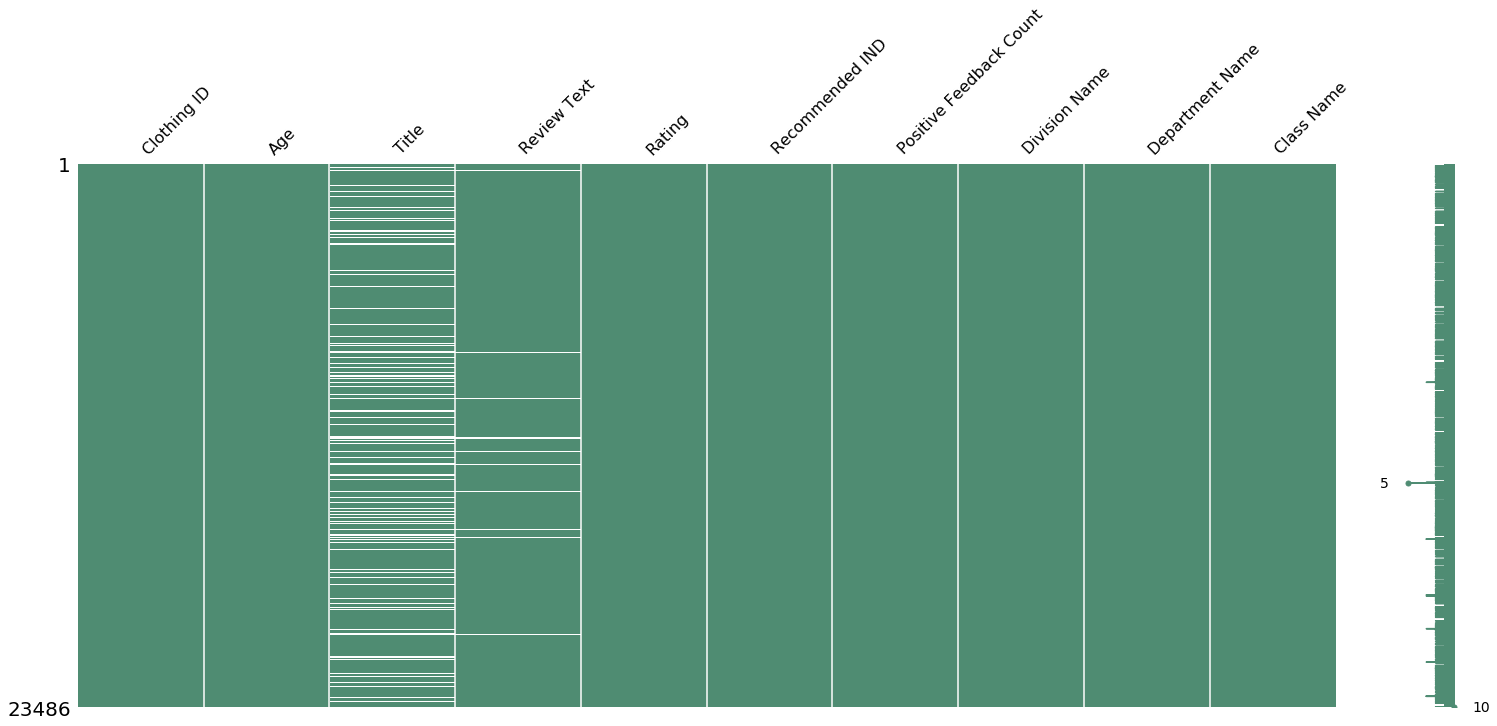

In [3]:
msno.matrix(data,color=(0.31, 0.55, 0.45))
plt.show()

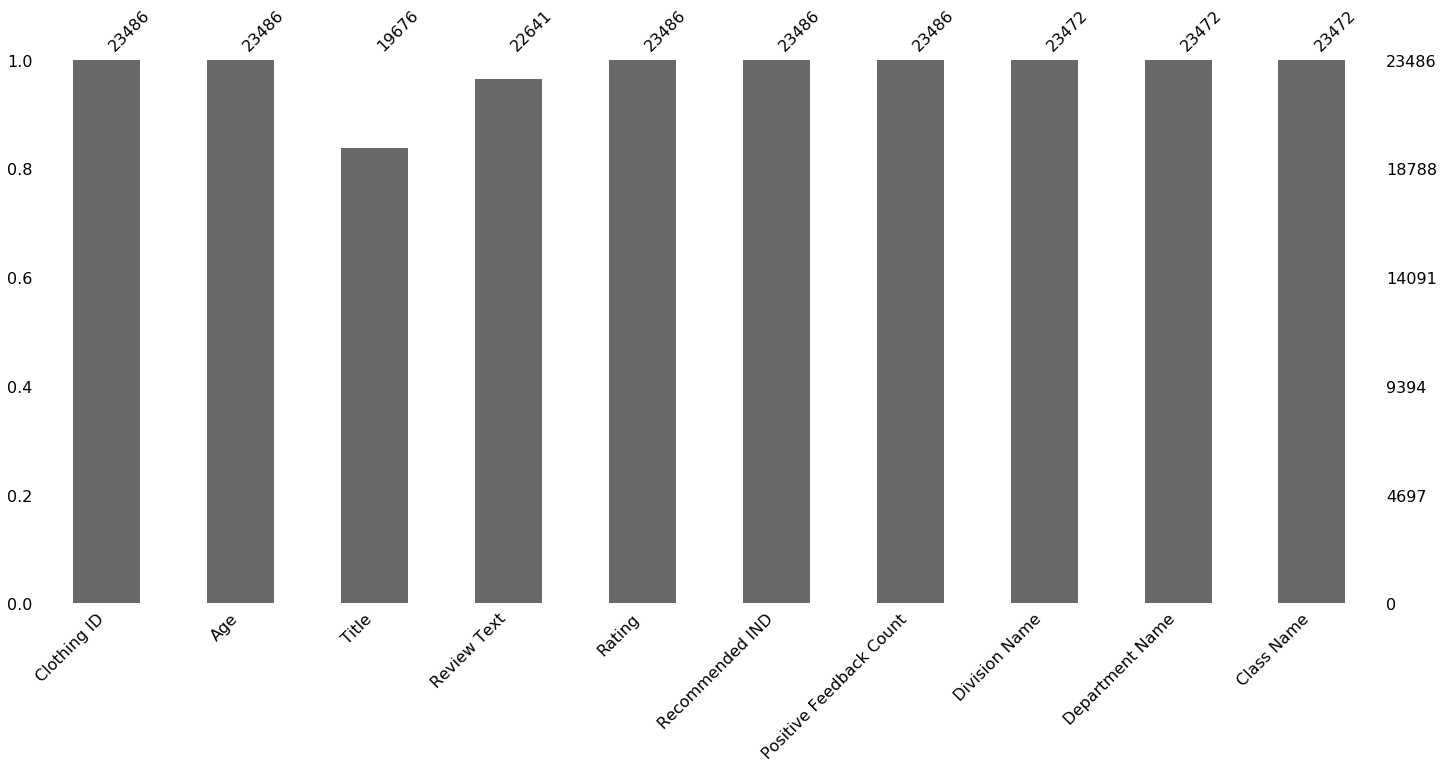

In [4]:
msno.bar(data) 

In [5]:
data.shape

(23486, 10)

In [6]:
print(tabulate({"Column Name":data.nunique().index.tolist(),
               "Unique Values":data.nunique().tolist(),
               "Missing Values":data.isnull().sum().tolist()},headers="keys",tablefmt="grid"))

+-------------------------+-----------------+------------------+
| Column Name             |   Unique Values |   Missing Values |
+=========================+=================+==================+
| Clothing ID             |            1206 |                0 |
+-------------------------+-----------------+------------------+
| Age                     |              77 |                0 |
+-------------------------+-----------------+------------------+
| Title                   |           13993 |             3810 |
+-------------------------+-----------------+------------------+
| Review Text             |           22634 |              845 |
+-------------------------+-----------------+------------------+
| Rating                  |               5 |                0 |
+-------------------------+-----------------+------------------+
| Recommended IND         |               2 |                0 |
+-------------------------+-----------------+------------------+
| Positive Feedback Count

In [7]:
data.dropna().describe()

Clothing ID           Age        Rating  Recommended IND  \
count  19662.000000  19662.000000  19662.000000     19662.000000   
mean     921.297274     43.260808      4.183145         0.818177   
std      200.227528     12.258122      1.112224         0.385708   
min        1.000000     18.000000      1.000000         0.000000   
25%      861.000000     34.000000      4.000000         1.000000   
50%      936.000000     41.000000      5.000000         1.000000   
75%     1078.000000     52.000000      5.000000         1.000000   
max     1205.000000     99.000000      5.000000         1.000000   

       Positive Feedback Count  
count             19662.000000  
mean                  2.652477  
std                   5.834285  
min                   0.000000  
25%                   0.000000  
50%                   1.000000  
75%                   3.000000  
max                 122.000000

In [8]:
data[["Title", "Division Name","Department Name","Class Name"]].describe(include=["O"]).T.drop("count",axis=1)

unique       top   freq
Title            13993  Love it!    136
Division Name        3   General  13850
Department Name      6      Tops  10468
Class Name          20   Dresses   6319

# Univariate Analysis

## Rating

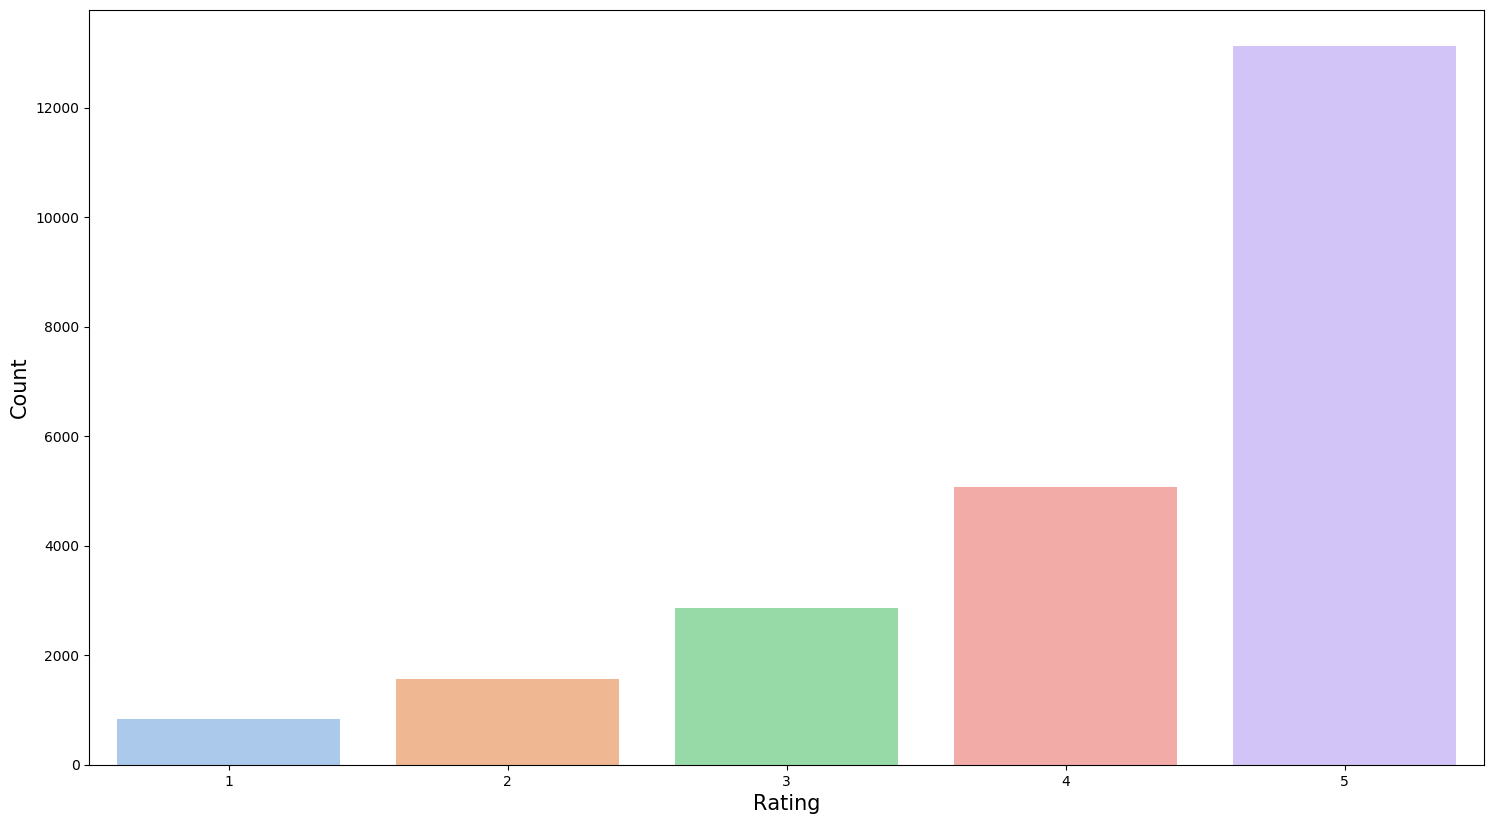

In [9]:
plt.figure(figsize=(18,10),dpi=100)
ax = sns.countplot(x=data['Rating'],palette=sns.color_palette("pastel"))
plt.xlabel("Rating",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.show()

**The plot shows that the dominant reviews were positive, suggesting that the e-commerce fairly satisfies its customers.**

## Rating Class

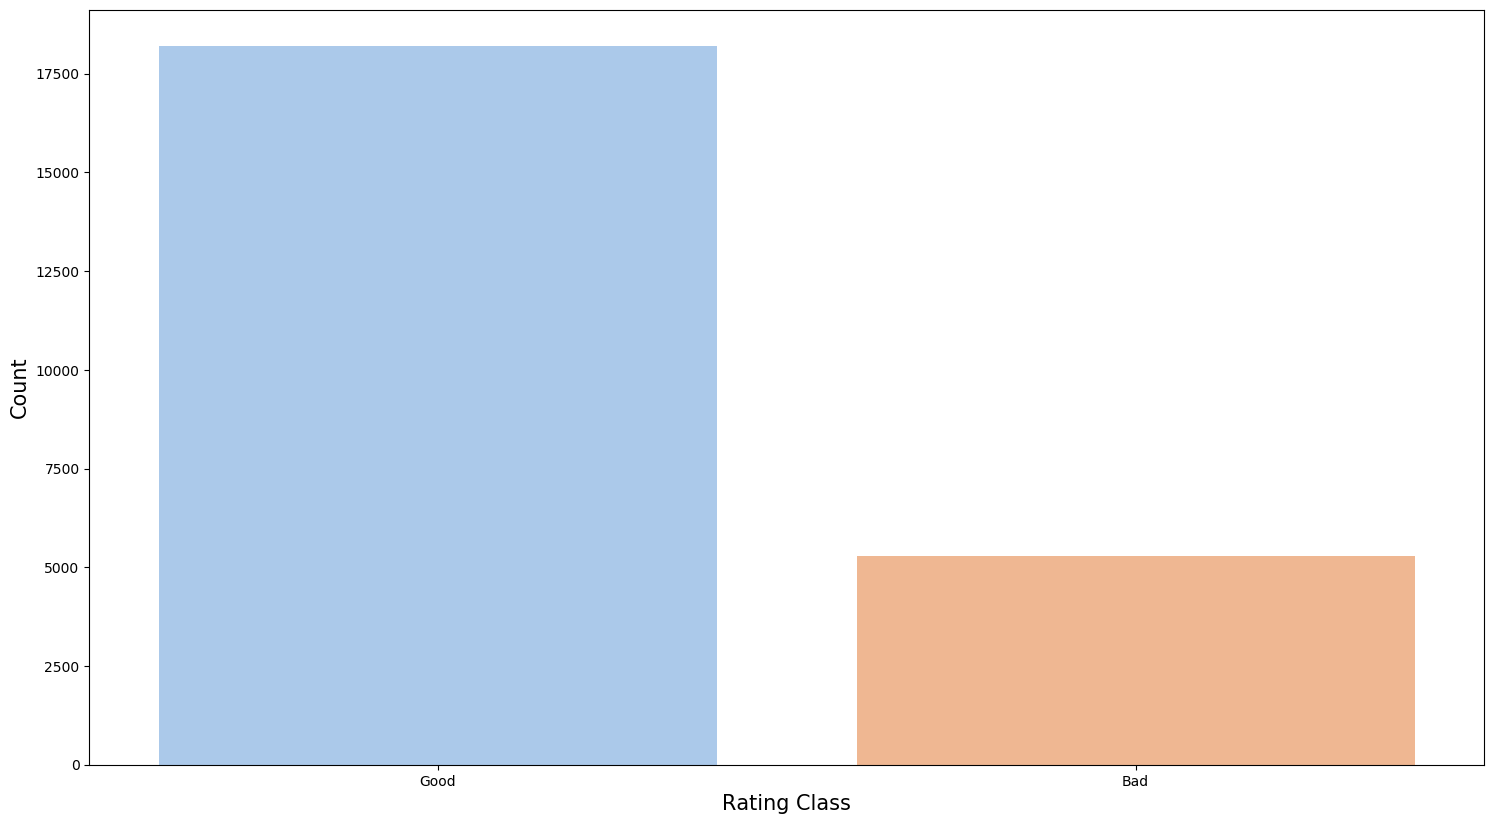

In [10]:
data['Rating_Class'] = data['Rating']
def grouping(x):
    if(x>3):
        return "Good"
    else:
        return "Bad"
    
data['Rating_Class'] = data['Rating_Class'].map(lambda x: grouping(x))
plt.figure(figsize=(18,10),dpi=100)
ax = sns.countplot(x=data['Rating_Class'],palette=sns.color_palette("pastel"))
plt.xlabel("Rating Class",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.show()

**Rating &nbsp; $>$&nbsp; 3 -> Good**<br>
**Rating $<=$ 3 -> Bad**

## Recommended IND

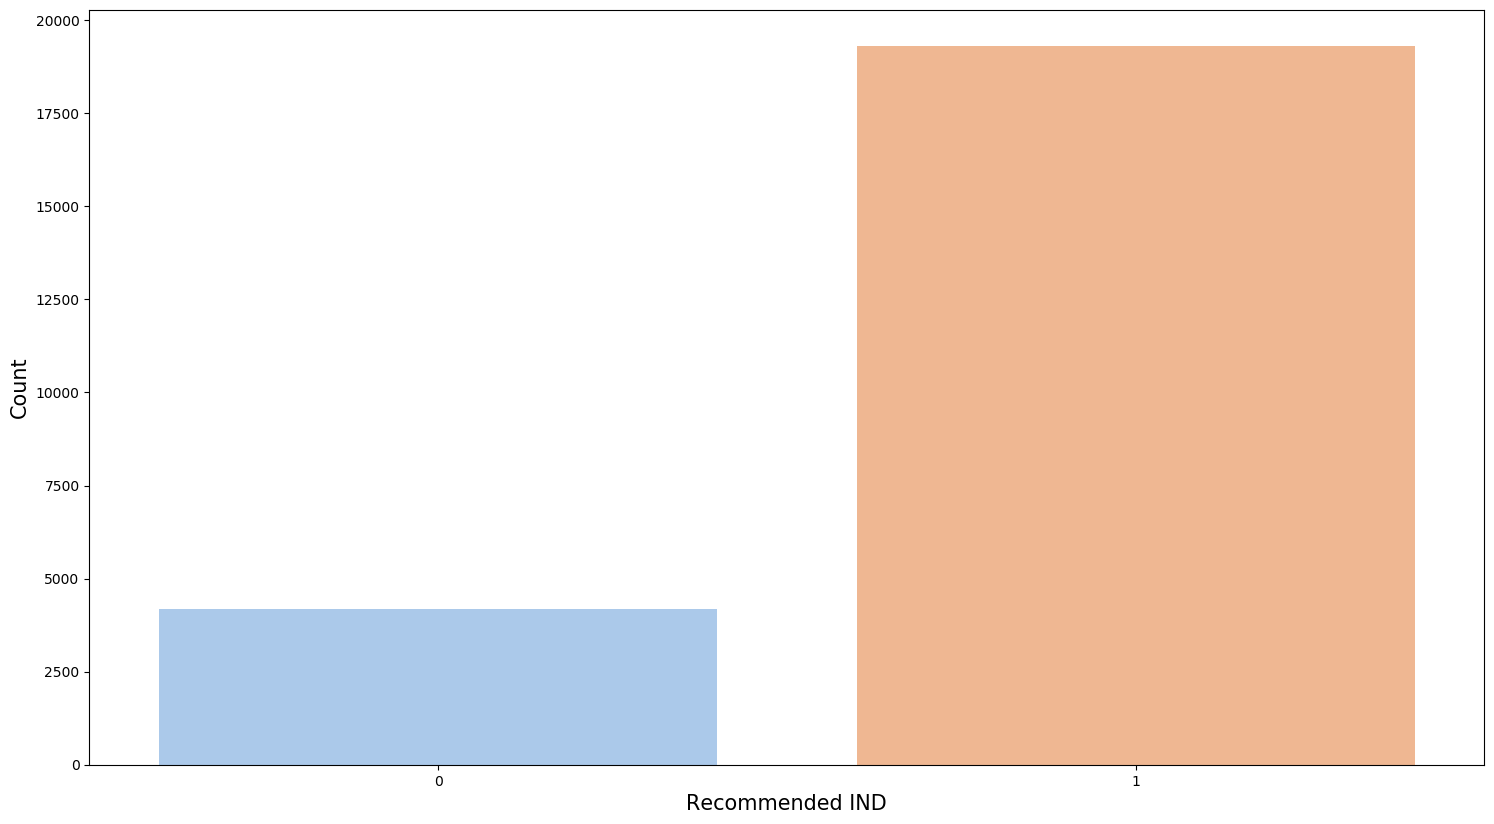

In [11]:
plt.figure(figsize=(18,10),dpi=100)
ax = sns.countplot(x=data['Recommended IND'],palette=sns.color_palette("pastel"))
plt.xlabel("Recommended IND",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.show()

**It may be axiomatic that a review with recommendation implies a higher rating and a positive sentiment. But then again, the processing of sentiments were based on a threshold of higher than rating of 3 for positive, and negative for the rest**

## Age

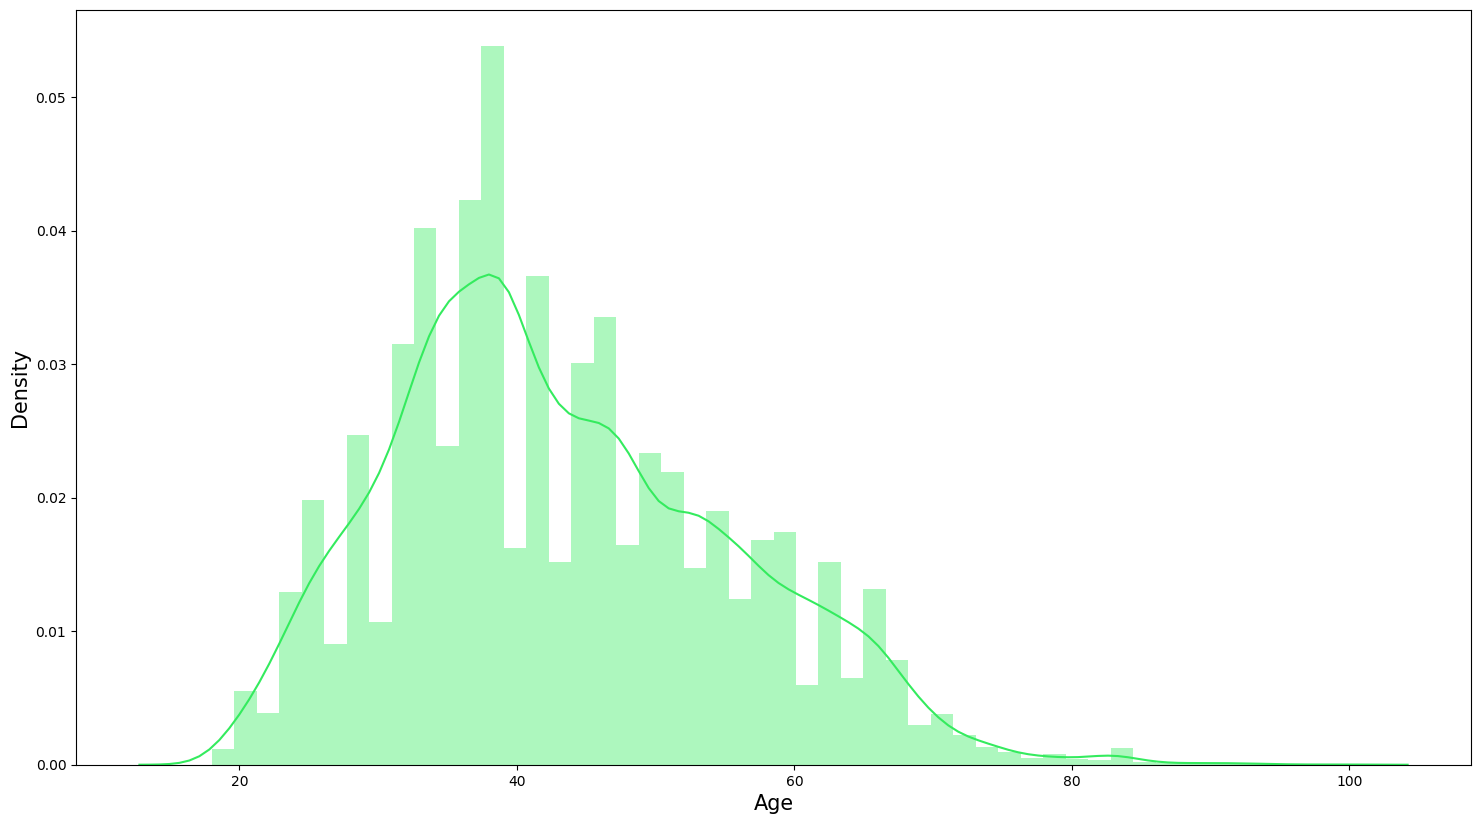

In [12]:
plt.figure(figsize=(18,10),dpi=100)
ax = sns.distplot(data['Age'],color="#34eb5e")
plt.xlabel("Age",fontsize=15)
plt.ylabel("Density",fontsize=15)
plt.show()

**The plot shows that the most engaged customers in reviewing purchased products were in the age range of 35 to 44.**

## Positive Feedback Count

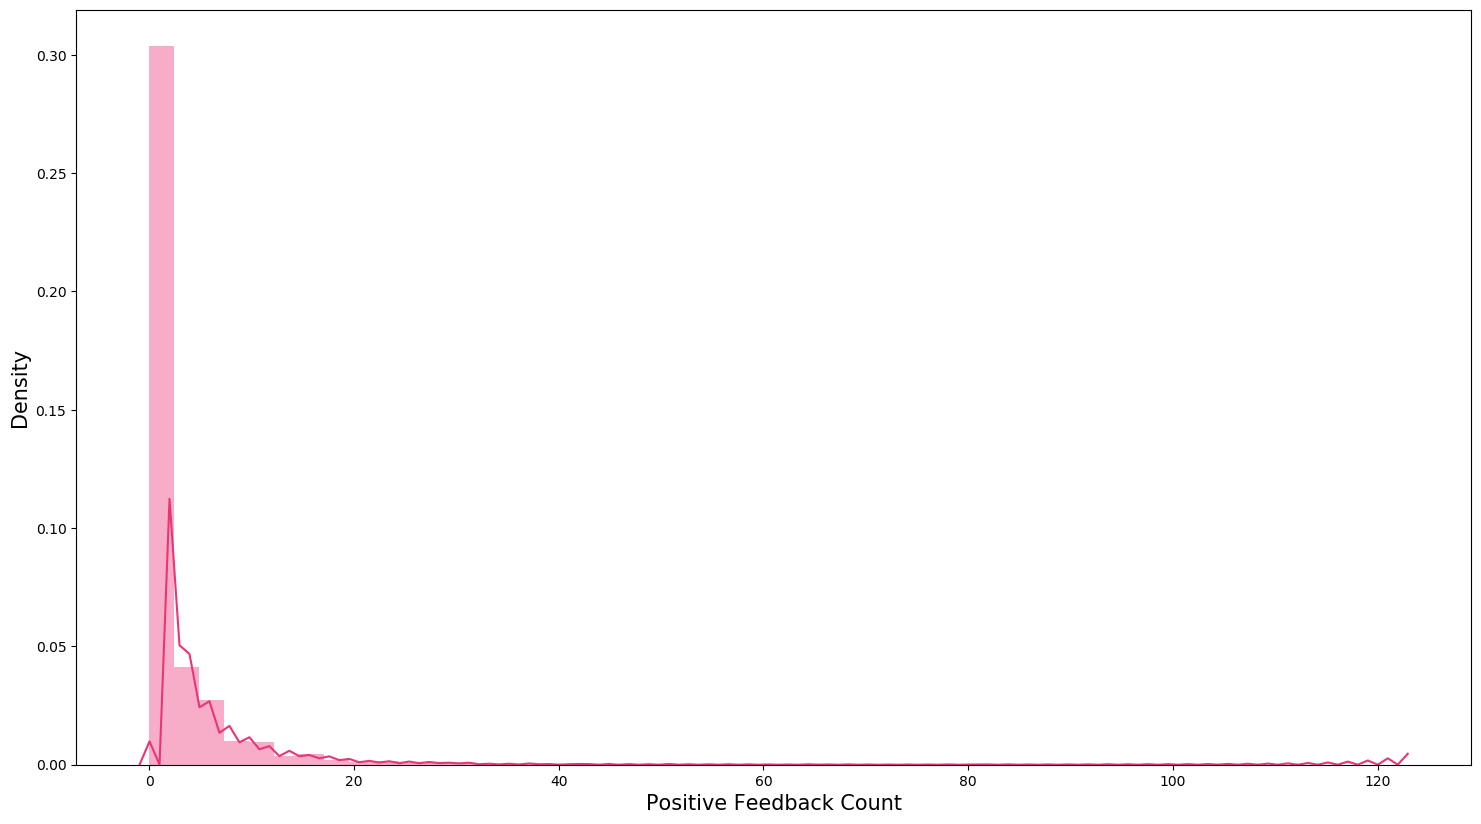

In [13]:
plt.figure(figsize=(18,10),dpi=100)
ax = sns.distplot(data['Positive Feedback Count'],color="#eb3477")
plt.xlabel("Positive Feedback Count",fontsize=15)
plt.ylabel("Density",fontsize=15)
plt.show()

**The plot shows that there is very less positive feedback count by most of the customers i.e < 20**

## Division Name

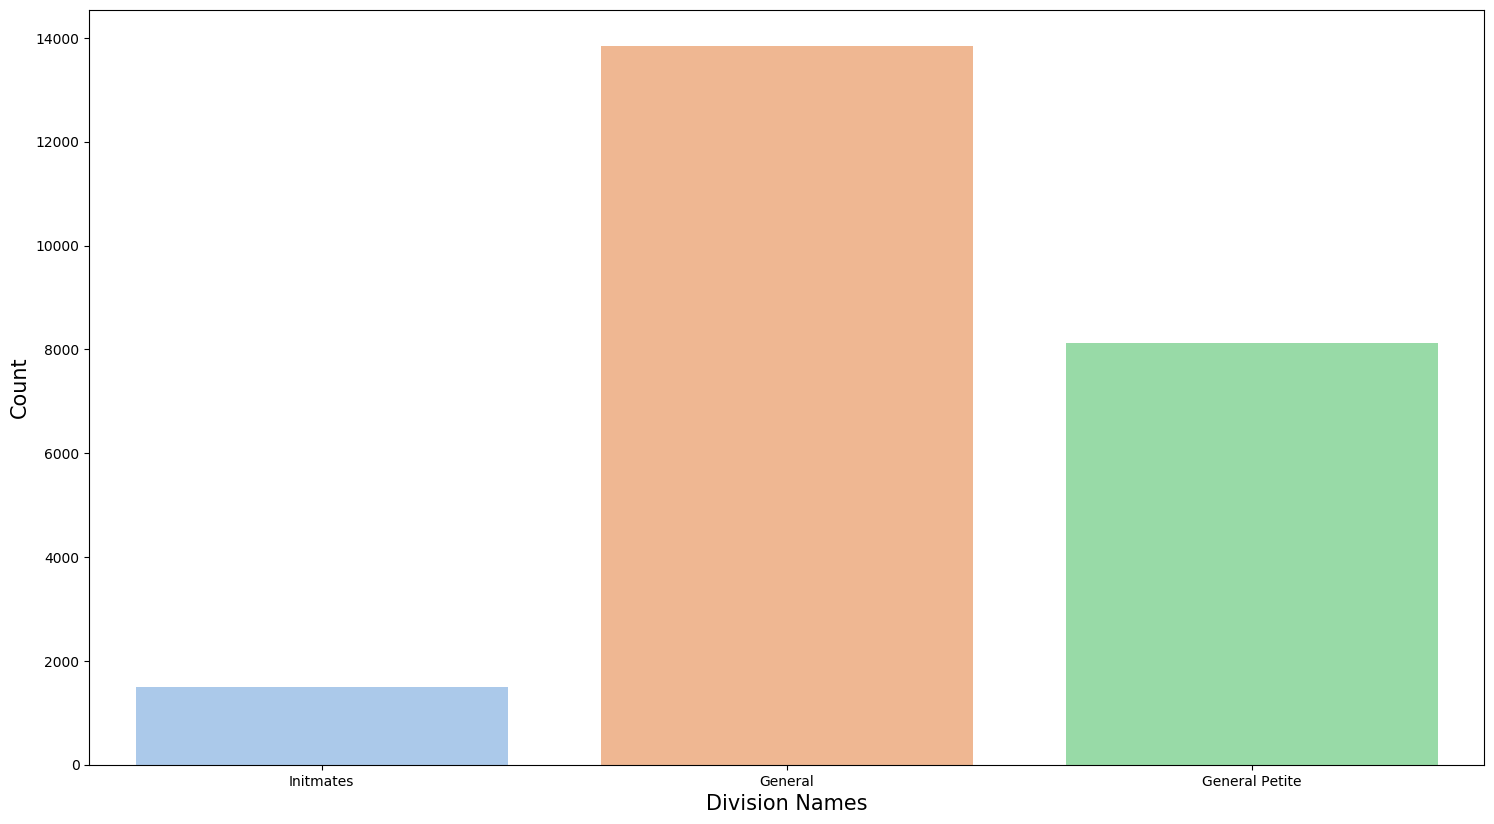

In [14]:
plt.figure(figsize=(18,10),dpi=100)
ax = sns.countplot(x=data['Division Name'],palette=sns.color_palette("pastel"))
plt.xlabel("Division Names",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.show()

**These plots gives the e-commerce an insight on the customer apparel sizes and clothing being most reviewed, i.e. General which refers to clothing size, and tops which refers to apparel types**

## Department Name

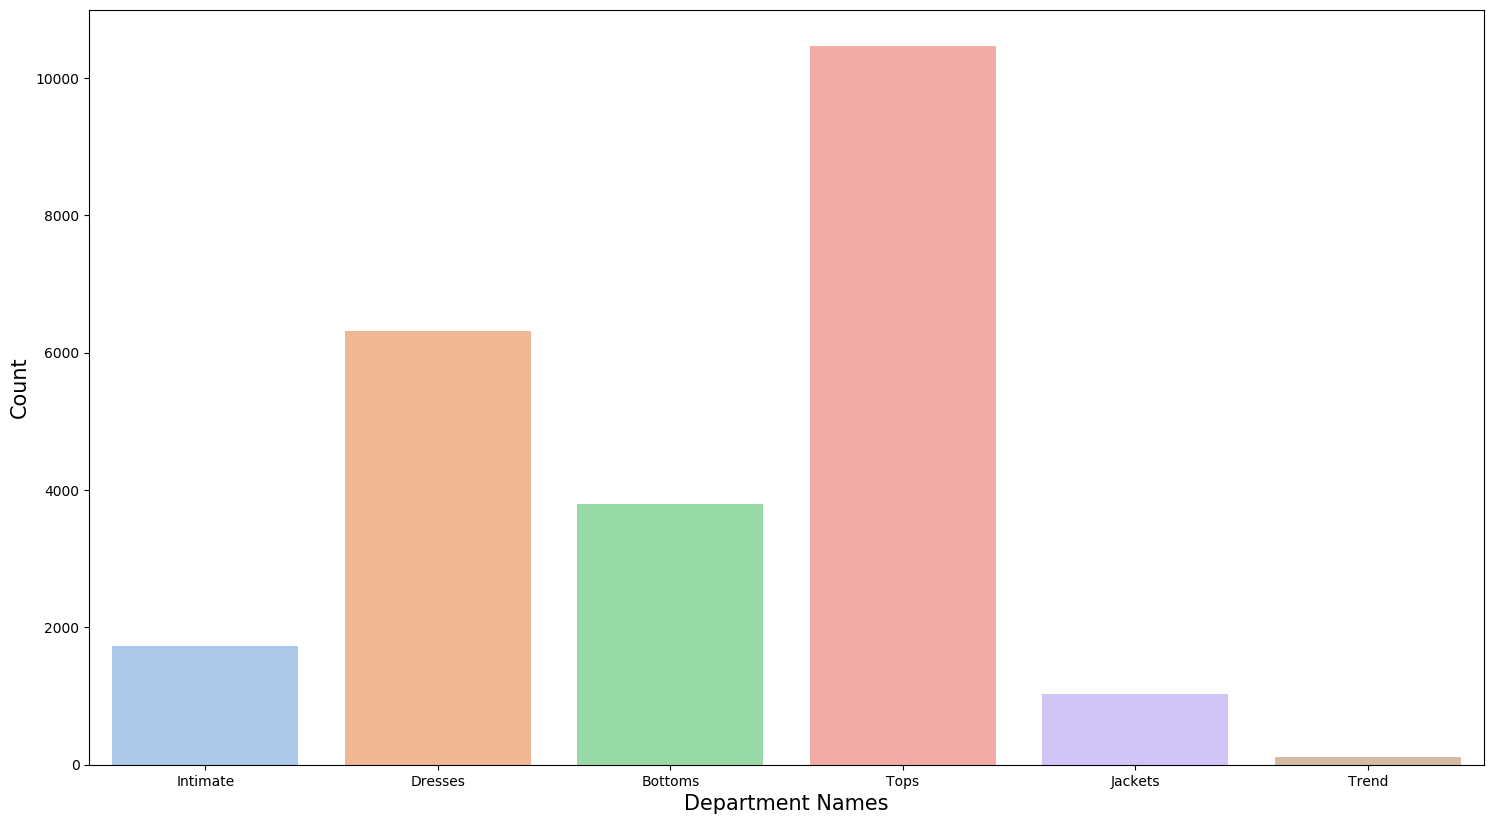

In [15]:
plt.figure(figsize=(18,10),dpi=100)
ax = sns.countplot(x=data['Department Name'],palette=sns.color_palette("pastel"))
plt.xlabel("Department Names",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.show()

## Class Name

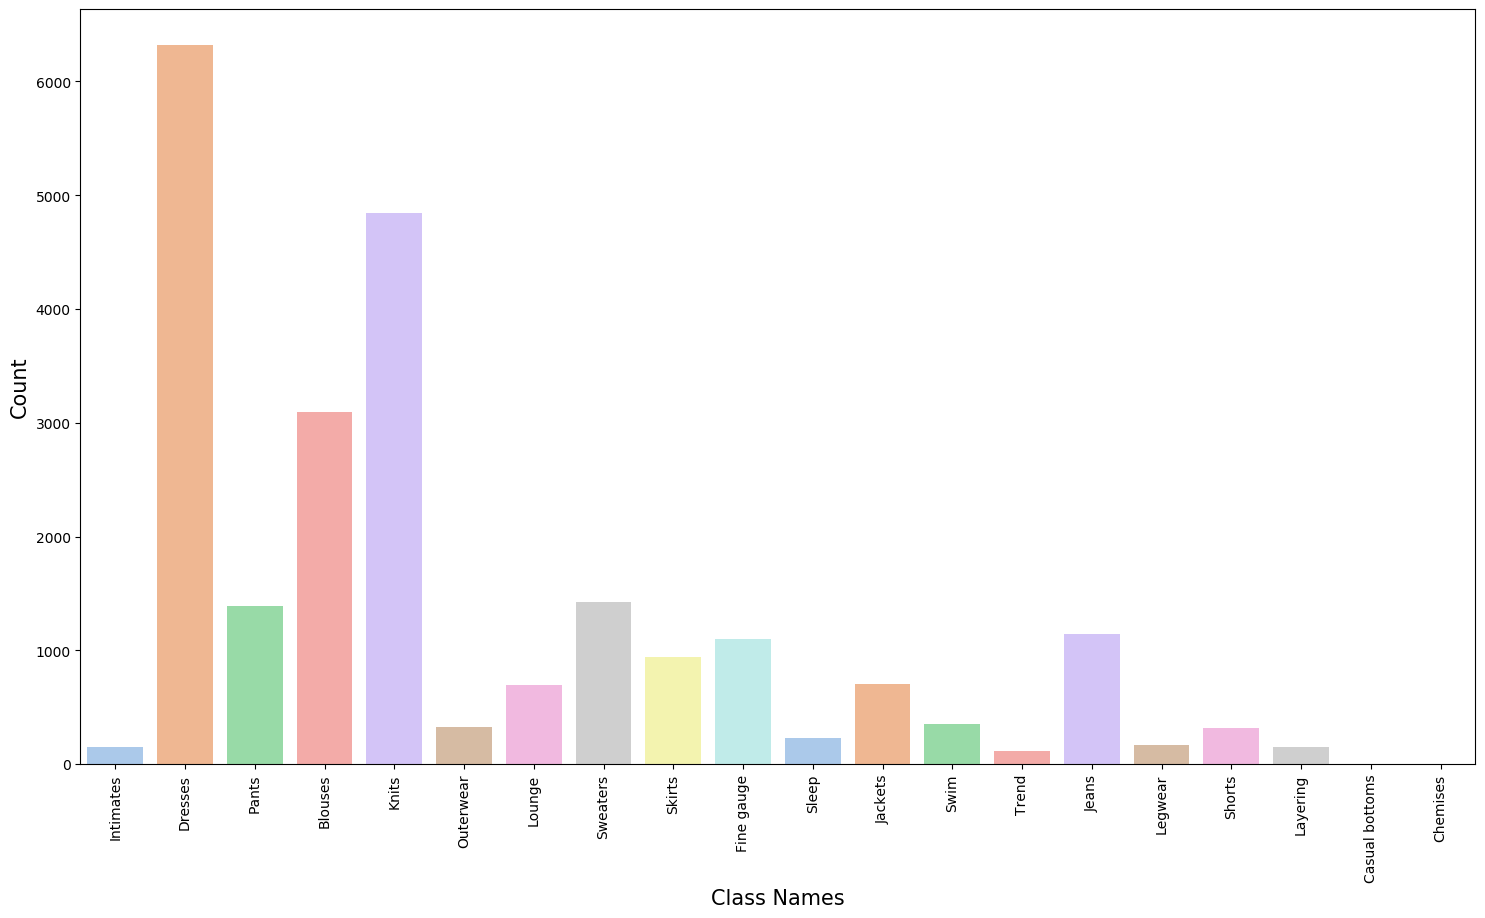

In [16]:
plt.figure(figsize=(18,10),dpi=100)
ax = sns.countplot(x=data['Class Name'],palette=sns.color_palette("pastel"))
plt.xlabel("Class Names",fontsize=15)
plt.xticks(rotation=90)
plt.ylabel("Count",fontsize=15)
plt.show()

**The above plot shows the frequency distribution of apparel classes most reviewed. The top three apparels are dresses,knits,and blouses**

## Most Popular Items  

In [17]:
print(tabulate({"Clothing ID":data['Clothing ID'].value_counts().index.tolist()[:10],
                "Counts":data['Clothing ID'].value_counts().tolist()[:10]}, headers="keys",tablefmt="grid"))

+---------------+----------+
|   Clothing ID |   Counts |
+===============+==========+
|          1078 |     1024 |
+---------------+----------+
|           862 |      806 |
+---------------+----------+
|          1094 |      756 |
+---------------+----------+
|          1081 |      582 |
+---------------+----------+
|           872 |      545 |
+---------------+----------+
|           829 |      527 |
+---------------+----------+
|          1110 |      480 |
+---------------+----------+
|           868 |      430 |
+---------------+----------+
|           895 |      404 |
+---------------+----------+
|           936 |      358 |
+---------------+----------+


## Most Reviewed(Good) Items

In [18]:
print(tabulate({"Clothing ID":data[data["Rating_Class"]=="Good"]['Clothing ID'].value_counts().index.tolist()[:10],
                "Counts":data[data["Rating_Class"]=="Good"]['Clothing ID'].value_counts().tolist()[:10]}, headers="keys",tablefmt="grid"))

+---------------+----------+
|   Clothing ID |   Counts |
+===============+==========+
|          1078 |      796 |
+---------------+----------+
|           862 |      627 |
+---------------+----------+
|          1094 |      584 |
+---------------+----------+
|          1081 |      471 |
+---------------+----------+
|           872 |      459 |
+---------------+----------+
|           829 |      406 |
+---------------+----------+
|          1110 |      377 |
+---------------+----------+
|           895 |      323 |
+---------------+----------+
|           868 |      295 |
+---------------+----------+
|           936 |      285 |
+---------------+----------+


## Most Reviewed(Bad) Items

In [19]:
print(tabulate({"Clothing ID":data[data["Rating_Class"]=="Bad"]['Clothing ID'].value_counts().index.tolist()[:10],
                "Counts":data[data["Rating_Class"]=="Bad"]['Clothing ID'].value_counts().tolist()[:10]}, headers="keys",tablefmt="grid"))

+---------------+----------+
|   Clothing ID |   Counts |
+===============+==========+
|          1078 |      228 |
+---------------+----------+
|           862 |      179 |
+---------------+----------+
|          1094 |      172 |
+---------------+----------+
|           868 |      135 |
+---------------+----------+
|           829 |      121 |
+---------------+----------+
|          1081 |      111 |
+---------------+----------+
|          1110 |      103 |
+---------------+----------+
|          1095 |       88 |
+---------------+----------+
|           872 |       86 |
+---------------+----------+
|           867 |       84 |
+---------------+----------+


## Word Count of Review

In [20]:
def wordcount(x):
    if(type(x)==type("String")):
        return len(x.split())
    elif(type(x)==type(1.0)):
        return 0
data['Word Count'] = data['Review Text'].map(lambda x: wordcount(x))

In [21]:
print("Total Number of Words in the Reviews :",sum(data['Word Count'].tolist()))

Total Number of Words in the Reviews : 1362913


In [22]:
print("Maximum Words used in the review :",max(data['Word Count'].tolist()))

Maximum Words used in the review : 115


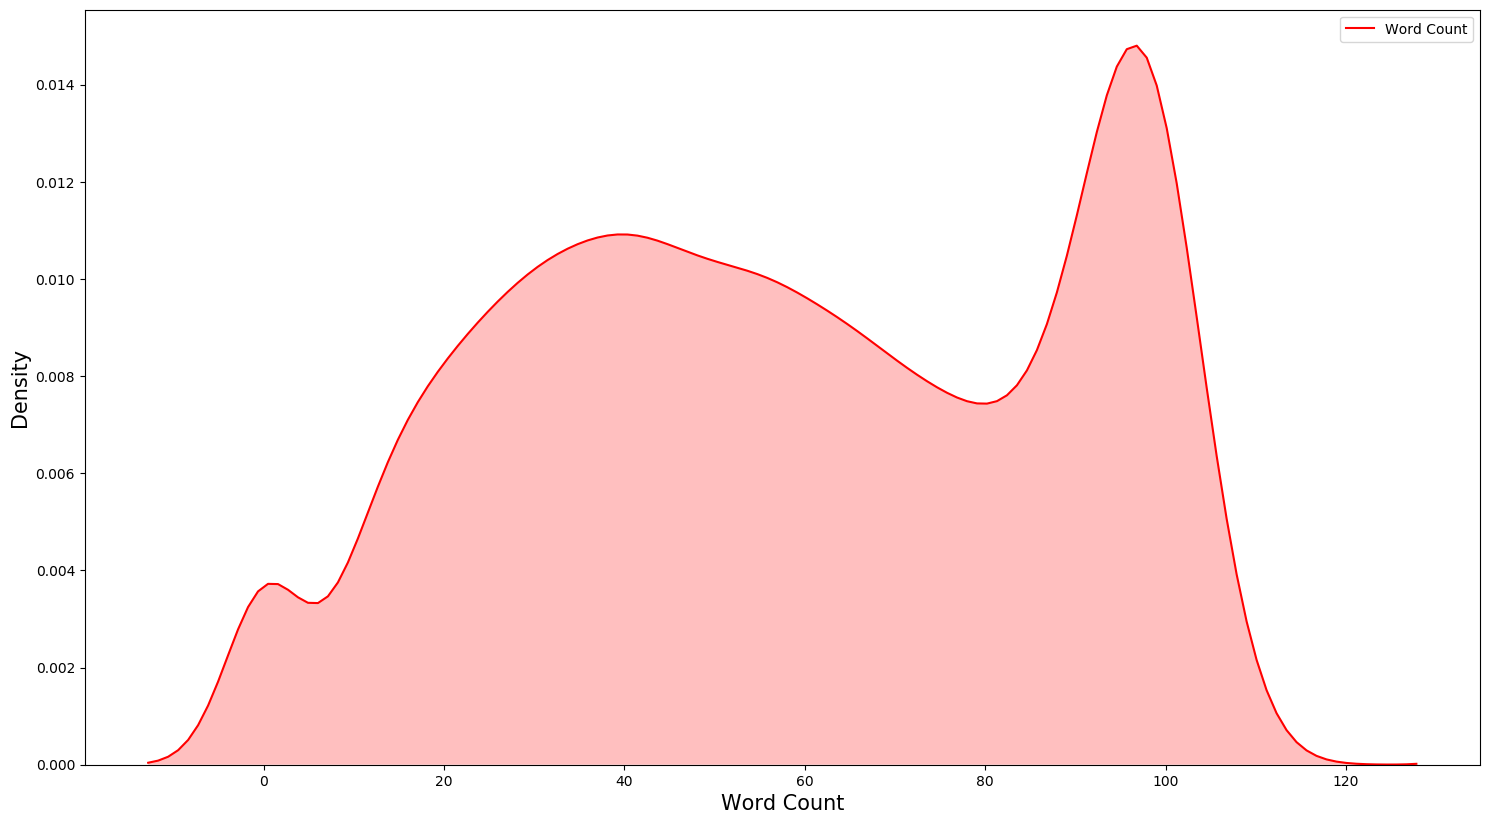

In [23]:
plt.figure(figsize=(18,10),dpi=100)
sns.kdeplot(data=data['Word Count'],color="r",shade=True)
plt.xlabel("Word Count",fontsize=15)
plt.ylabel("Density",fontsize=15)
plt.show()

# Bivariate Analysis

## Word Count by Rating,Recommended IND

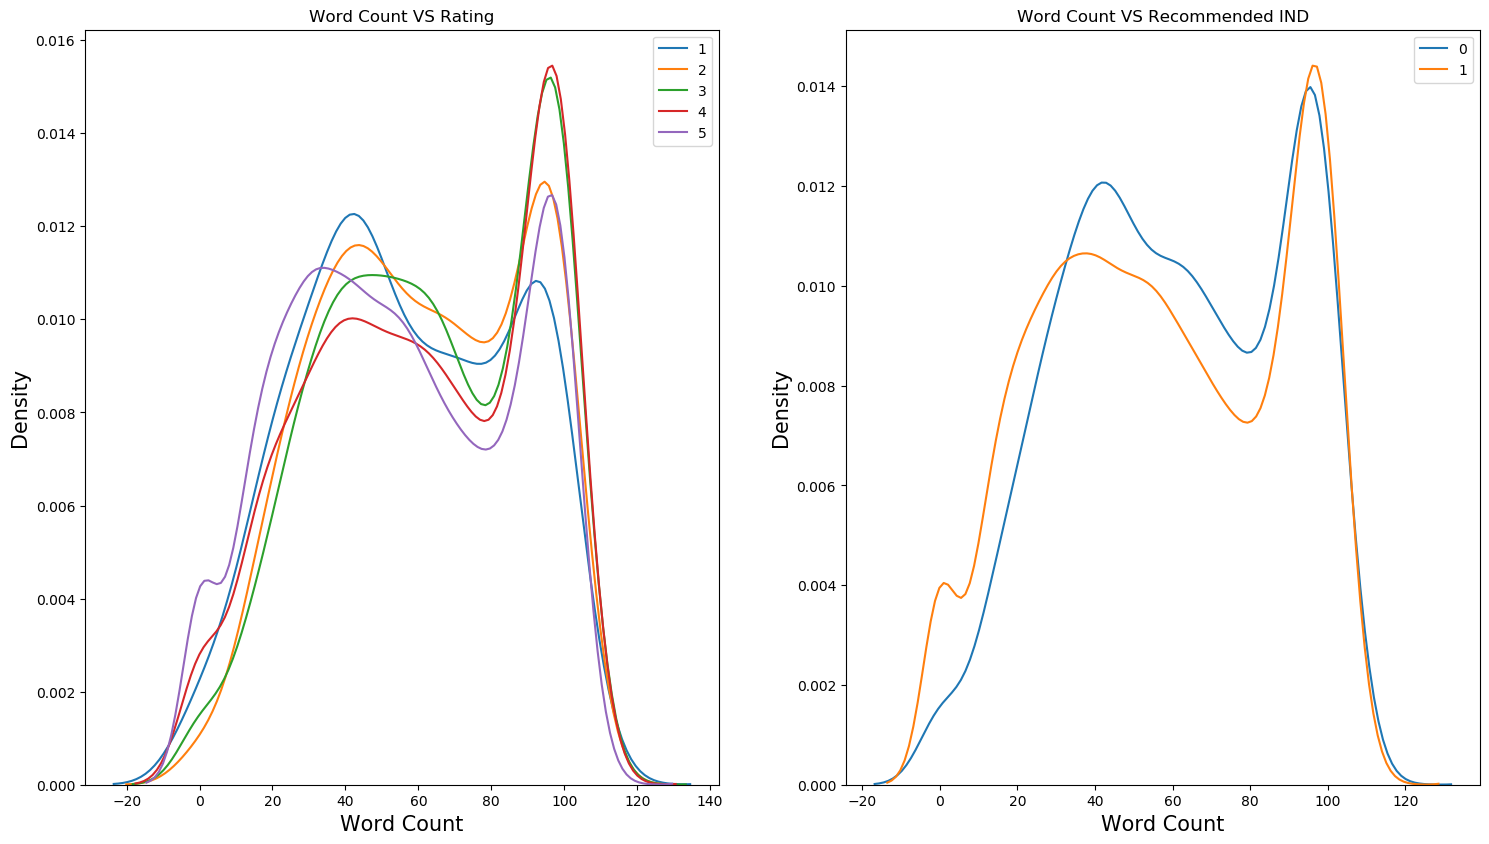

In [24]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(18,10),dpi=100)
the_grid = gridspec.GridSpec(1, 2)

plt.subplot(the_grid[0],  title='Word Count VS Rating')
for i in range(1,6):
    sns.kdeplot(data=data[data['Rating']==i]['Word Count'],label=i)
plt.xlabel("Word Count",fontsize=15)
plt.ylabel("Density",fontsize=15)

#------------------------------------------------------------------------------------------------------------
plt.subplot(the_grid[1],  title='Word Count VS Recommended IND')
for i in range(2):
    sns.kdeplot(data=data[data['Recommended IND']==i]['Word Count'],label=i)
plt.xlabel("Word Count",fontsize=15)
plt.ylabel("Density",fontsize=15)

plt.show()

**The plot shows that regardless of the rating in a review, apparel type, or recommendation, the users had qualitatively the same length of words in their reviews.**

## Age Grouping VS Rating Class

In [25]:
print("Minimum Age :",min(data['Age']))
print("Maximum Age :",max(data['Age']))

Minimum Age : 18
Maximum Age : 99


In [26]:
ag = []
for i in [[18,25],[26,30],[31,40],[41,50],[51,60],[61,70],[71,100]]:
    ag.append([str(i[0])+str("-")+str(i[1]),len(data[(data['Age']<=i[1])&(data['Age']>=i[0])]),len(data[(data["Rating_Class"]=="Good")&((data['Age']<=i[1])&(data['Age']>=i[0]))]),
              len(data[(data['Rating_Class']=="Bad")&((data['Age']<=i[1])&(data['Age']>=i[0]))])])
    
Age_List = pd.DataFrame(ag,columns=['Age_Group','Total_Reviews','Good_Reviews','Bad_Reviews'])

In [27]:
Age_List

Age_Group  Total_Reviews  Good_Reviews  Bad_Reviews
0     18-25           1223           991          232
1     26-30           2115          1573          542
2     31-40           7912          6054         1858
3     41-50           5908          4530         1378
4     51-60           3891          3098          793
5     61-70           2057          1660          397
6    71-100            380           302           78

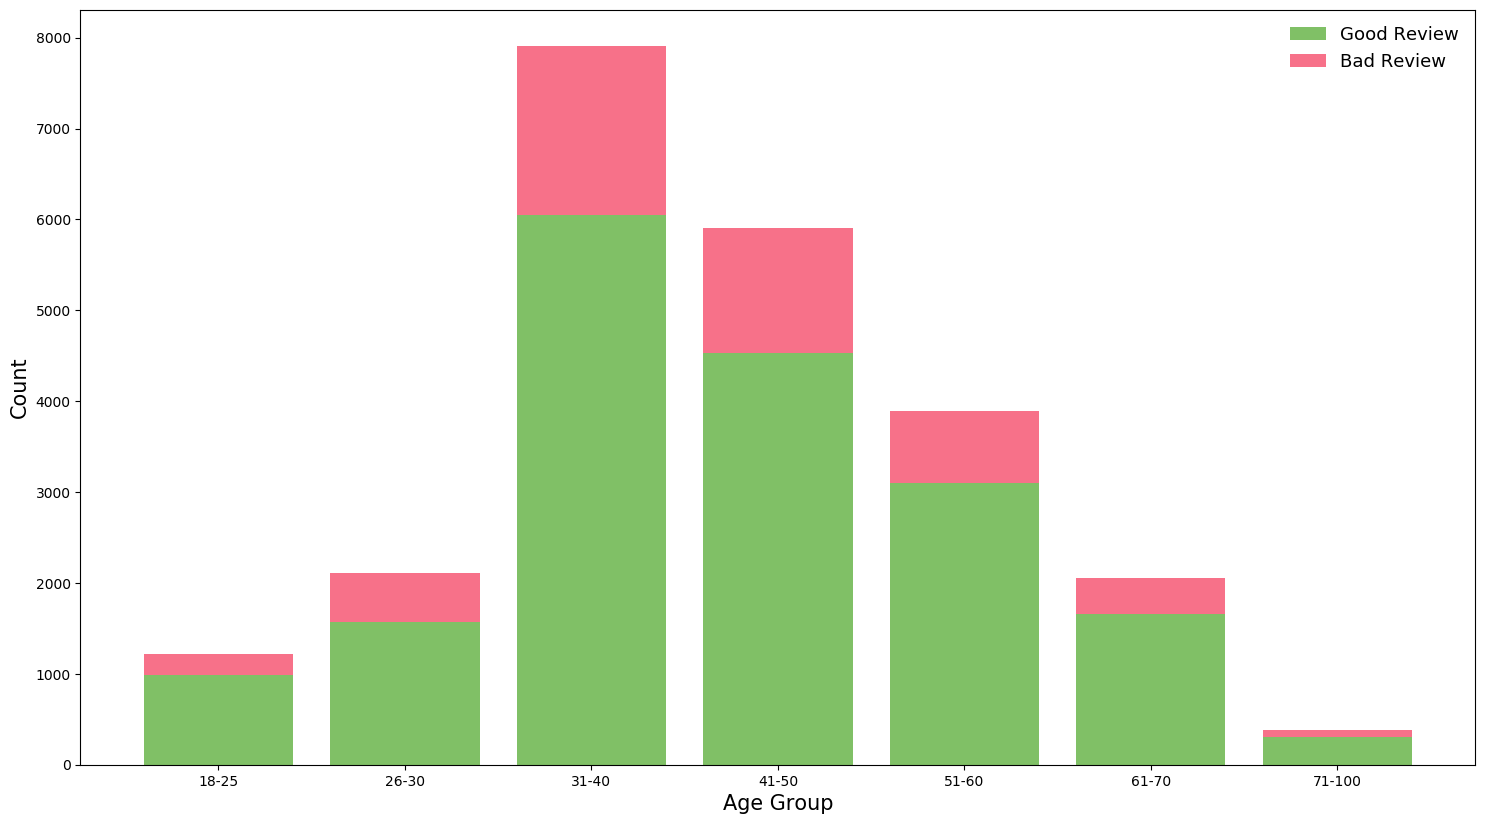

In [28]:
plt.figure(figsize=(18,10),dpi=100)
plt.bar(Age_List.drop(['Total_Reviews'],axis=1)['Age_Group'],Age_List.drop(['Total_Reviews'],axis=1)['Good_Reviews'],color=sns.color_palette('summer',1))
plt.bar(Age_List.drop(['Total_Reviews'],axis=1)['Age_Group'],Age_List.drop(['Total_Reviews'],axis=1)['Bad_Reviews']
       ,bottom=Age_List.drop(['Total_Reviews'],axis=1)['Good_Reviews'],color=sns.color_palette('husl',1))
plt.legend(['Good Review','Bad Review'],frameon=False,fontsize=13)
plt.xlabel("Age Group",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.show()

**The plot shows that the most engaged customers in reviewing purchased products were in the age range of 35 to 44. In addition, the plot suggests that they have the most positive reviews on their purchased products. From this, we have two points to consider:<br>
(1)the said age group is the most satisfied group in the range of customers, thus, the e-commerce at review must focus on maintaining this segment, and<br> 
(2)the e-commerce entity can explore why other age groups are comparatively less satisfied than the age group 35 to 44.**

## Recommended IND VS Rating Class

In [29]:
Recommend_IND = pd.crosstab(index=data['Rating_Class'],columns=data['Recommended IND'])
Recommend_IND

Recommended IND     0      1
Rating_Class                
Bad              3979   1299
Good              193  18015

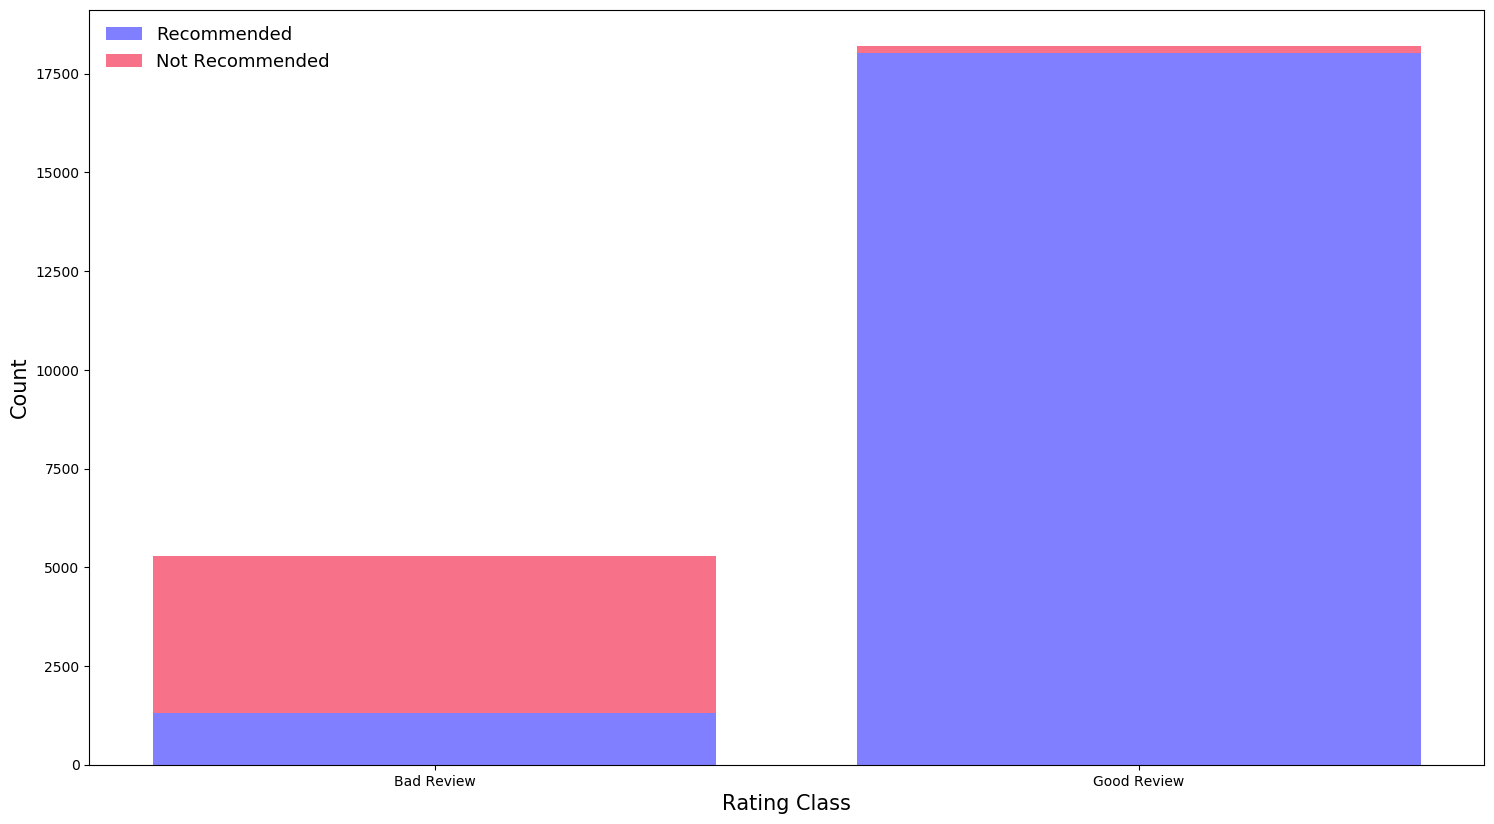

In [30]:
plt.figure(figsize=(18,10),dpi=100)
plt.bar(['Bad Review','Good Review'],Recommend_IND[1],color=sns.color_palette('cool',1))
plt.bar(['Bad Review','Good Review'],Recommend_IND[0]
       ,bottom=Recommend_IND[1],color=sns.color_palette('husl',1))
plt.legend(['Recommended','Not Recommended'],frameon=False,fontsize=13)
plt.xlabel("Rating Class",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.show()

**The plot supports the assumption that a review rating mirrors its recommendation status, i.e. higher rating means recommendation and viceversa**

## Division Name by  Department Name

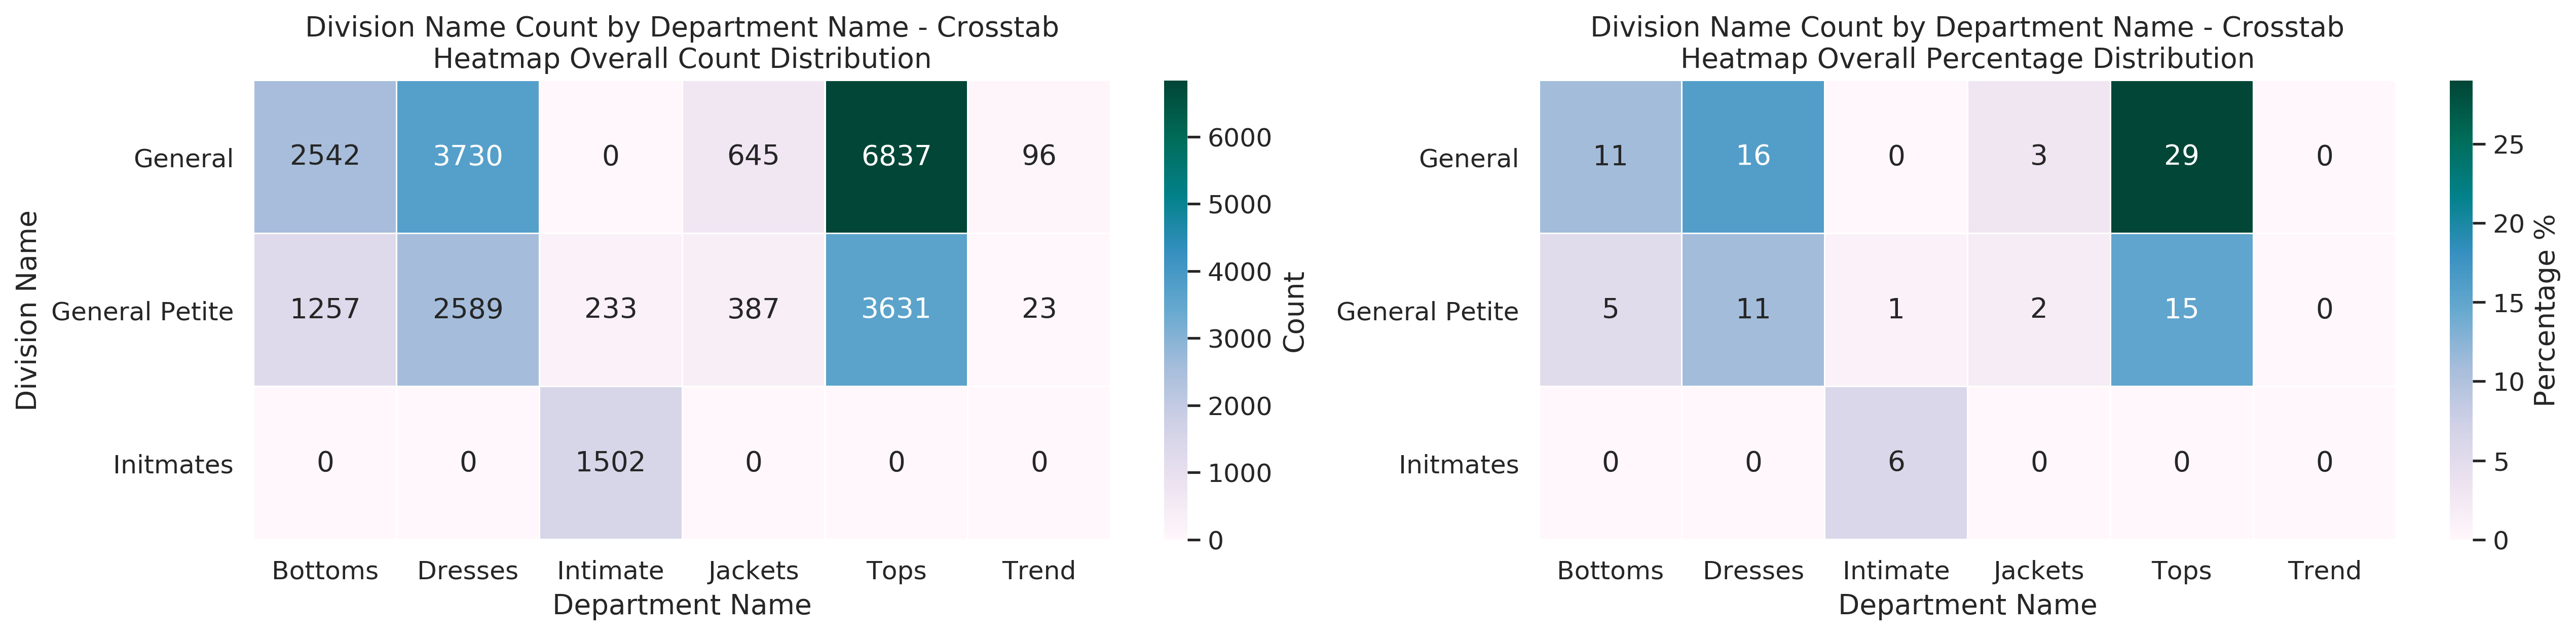

In [31]:
plt.figure(figsize=(20,4),dpi=300)
the_grid = gridspec.GridSpec(1, 2)

sns.set(font_scale=1.1)
plt.subplot(the_grid[0],  title='Division Name Count by Department Name - Crosstab\nHeatmap Overall Count Distribution')
sns.heatmap(pd.crosstab(index=data["Division Name"],columns=data["Department Name"]),
            annot=True, linewidths=.5, fmt='g', cmap='PuBuGn',
            cbar_kws={'label': 'Count'})

plt.subplot(the_grid[1],  title='Division Name Count by Department Name - Crosstab\nHeatmap Overall Percentage Distribution')
ax = sns.heatmap(pd.crosstab(index=data["Division Name"],columns=data["Department Name"],normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, fmt='g', cmap='PuBuGn',
            cbar_kws={'label': 'Percentage %'})
ax.set_ylabel("")
plt.show()

**Plot 1 reveals the dominance of general-sized tops, while plot 2 supports this inference**

## Class Name by  Department Name

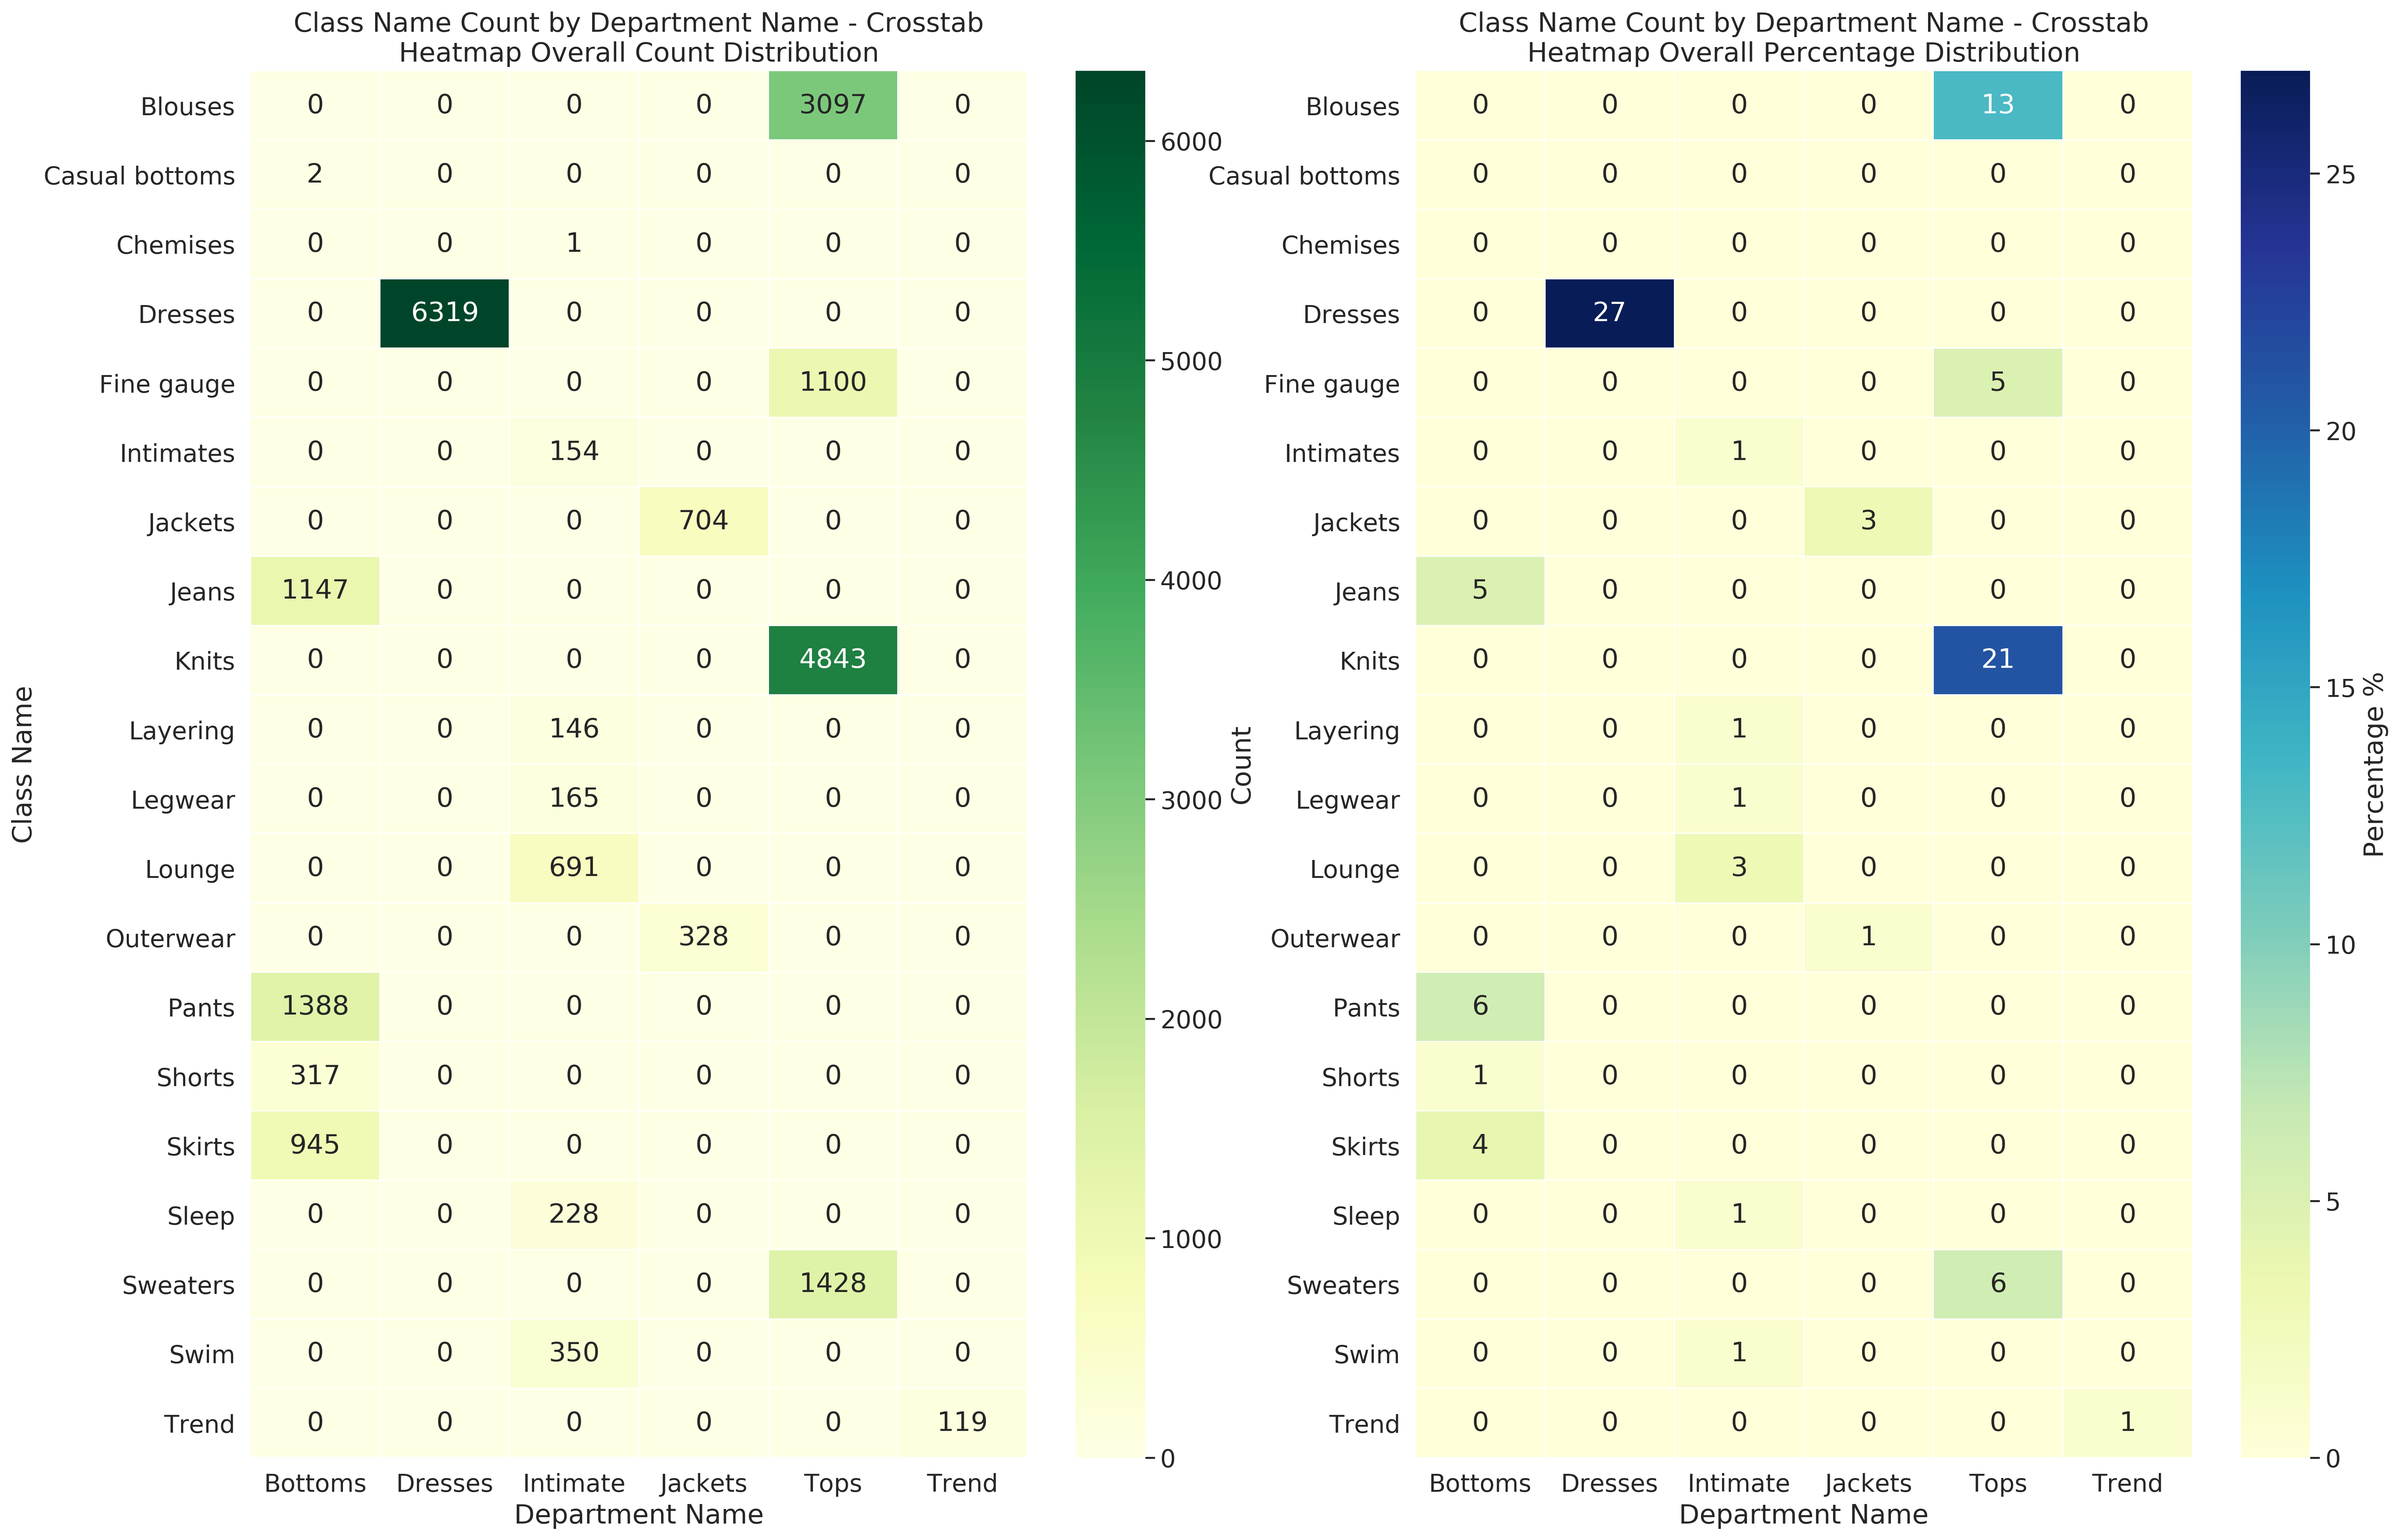

In [32]:
plt.figure(figsize=(24,16),dpi=300)
the_grid = gridspec.GridSpec(1, 2)

sns.set(font_scale=1.4) 
plt.subplot(the_grid[0],  title='Class Name Count by Department Name - Crosstab\nHeatmap Overall Count Distribution')
sns.heatmap(pd.crosstab(index=data["Class Name"],columns=data["Department Name"]),
            annot=True, linewidths=.5, fmt='g', cmap='YlGn',
            cbar_kws={'label': 'Count'})

plt.subplot(the_grid[1],  title='Class Name Count by Department Name - Crosstab\nHeatmap Overall Percentage Distribution')
ax = sns.heatmap(pd.crosstab(index=data["Class Name"],columns=data["Department Name"],normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, fmt='g', cmap='YlGnBu',
            cbar_kws={'label': 'Percentage %'})
ax.set_ylabel("")
plt.show()

**Plot 1 reveals the dominance of dress among apparel types, and supported by plot 2** 

## Class Name by Division Name

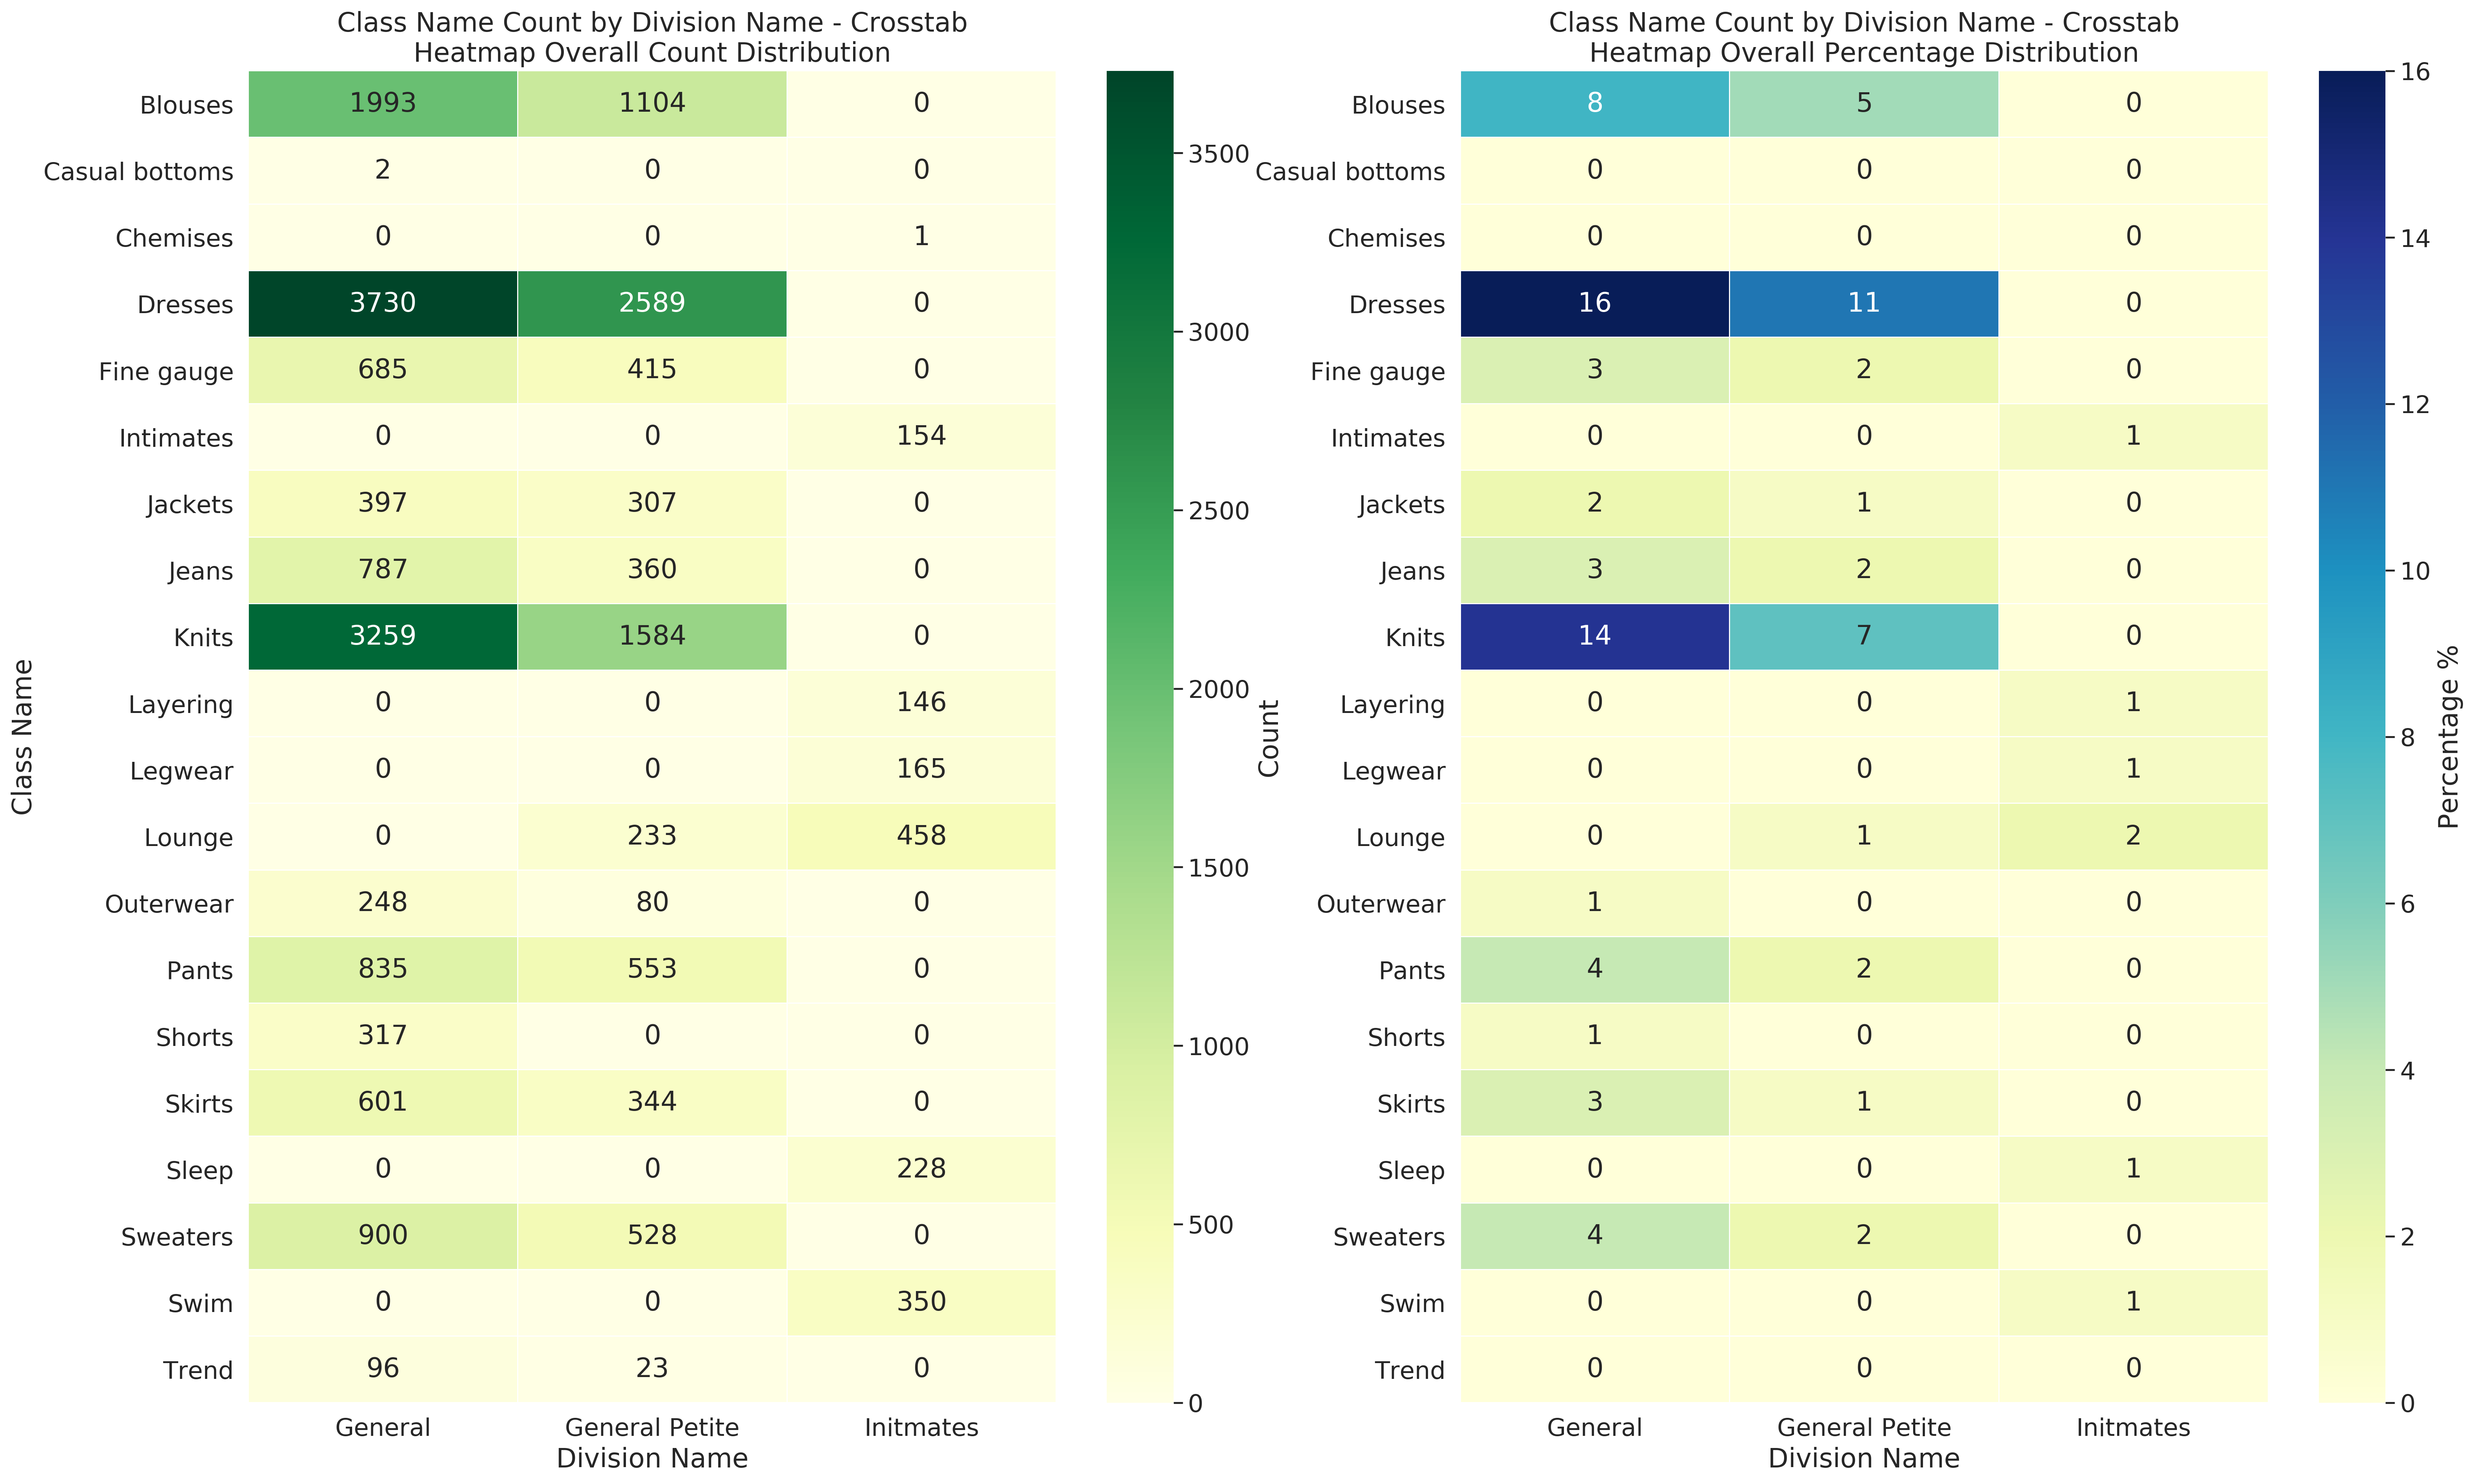

In [33]:
plt.figure(figsize=(26,16),dpi=300)
the_grid = gridspec.GridSpec(1, 2)

sns.set(font_scale=1.45) 
plt.subplot(the_grid[0],  title='Class Name Count by Division Name - Crosstab\nHeatmap Overall Count Distribution')
sns.heatmap(pd.crosstab(index=data["Class Name"],columns=data["Division Name"]),
            annot=True, linewidths=.5, fmt='g', cmap='YlGn',
            cbar_kws={'label': 'Count'})

plt.subplot(the_grid[1],  title='Class Name Count by Division Name - Crosstab\nHeatmap Overall Percentage Distribution')
ax = sns.heatmap(pd.crosstab(index=data["Class Name"],columns=data["Division Name"],normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, fmt='g', cmap='YlGnBu',
            cbar_kws={'label': 'Percentage %'})
ax.set_ylabel("")
plt.show()

**Plot 1 reveals the most reviewed apparel types as general-sized blouses, dresses, and knits. However, plot 2  shows that most reviews on dresses are from general petite sizes**

## Recommended IND by Department and Division

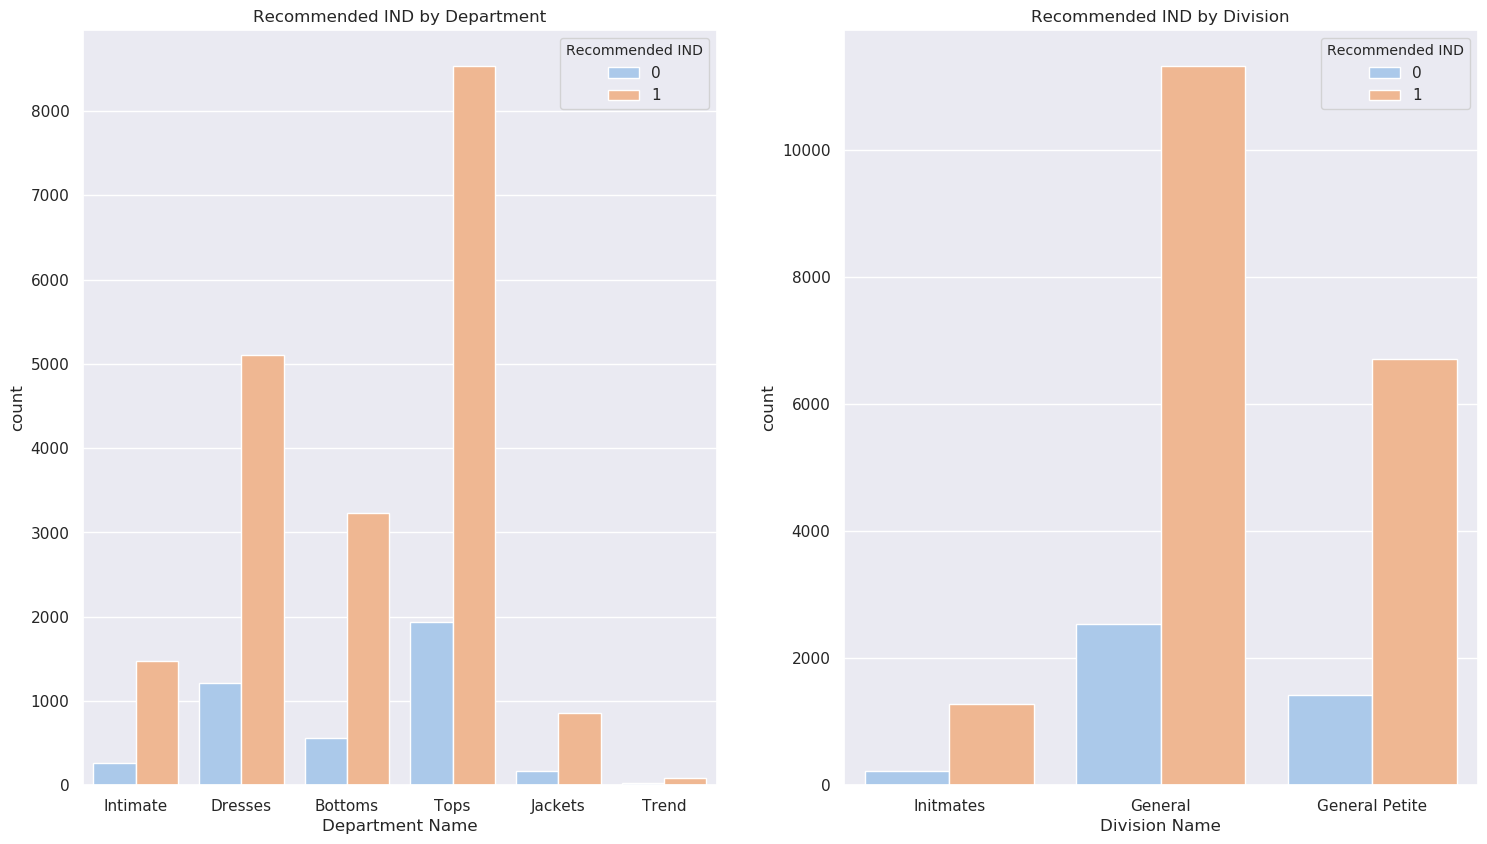

In [34]:
plt.figure(figsize=(18,10),dpi=100)
the_grid = gridspec.GridSpec(1, 2)

sns.set(font_scale=1) 
plt.subplot(the_grid[0],  title='Recommended IND by Department')
sns.countplot(x=data["Department Name"],hue=data["Recommended IND"],palette=sns.color_palette('pastel'))

plt.subplot(the_grid[1],  title='Recommended IND by Division')
sns.countplot(x=data["Division Name"],hue=data["Recommended IND"],palette=sns.color_palette('pastel'))

plt.show()

**Plot corroborates the findings the dominance of 'General'-sized 'Tops'**

## Rating by Department and Division

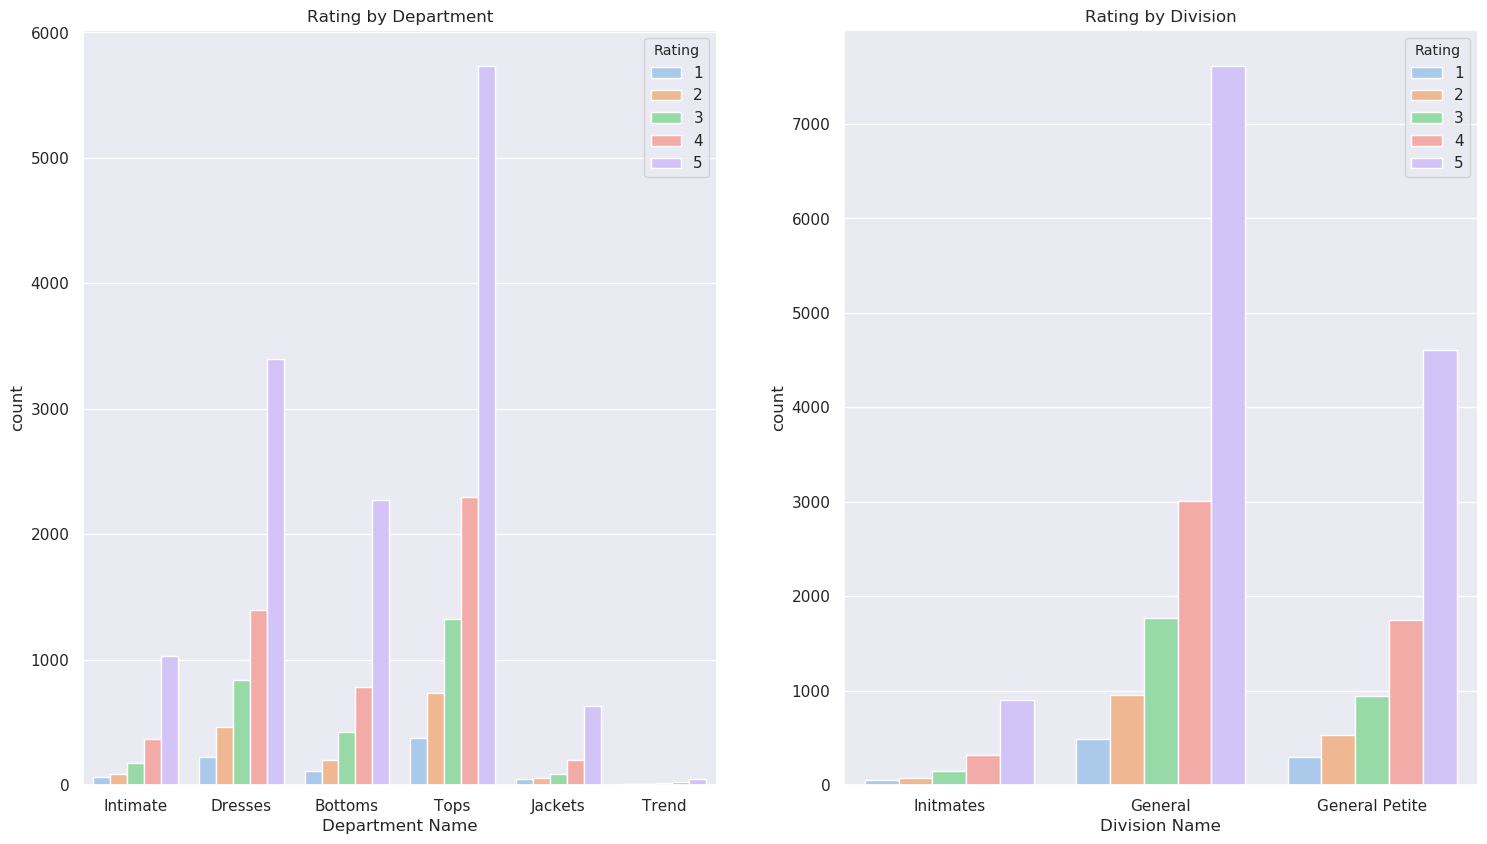

In [35]:
plt.figure(figsize=(18,10),dpi=100)
the_grid = gridspec.GridSpec(1, 2)

sns.set(font_scale=1) 
plt.subplot(the_grid[0],  title='Rating by Department')
sns.countplot(x=data["Department Name"],hue=data["Rating"],palette=sns.color_palette('pastel'))

plt.subplot(the_grid[1],  title='Rating by Division')
sns.countplot(x=data["Division Name"],hue=data["Rating"],palette=sns.color_palette('pastel'))

plt.show()

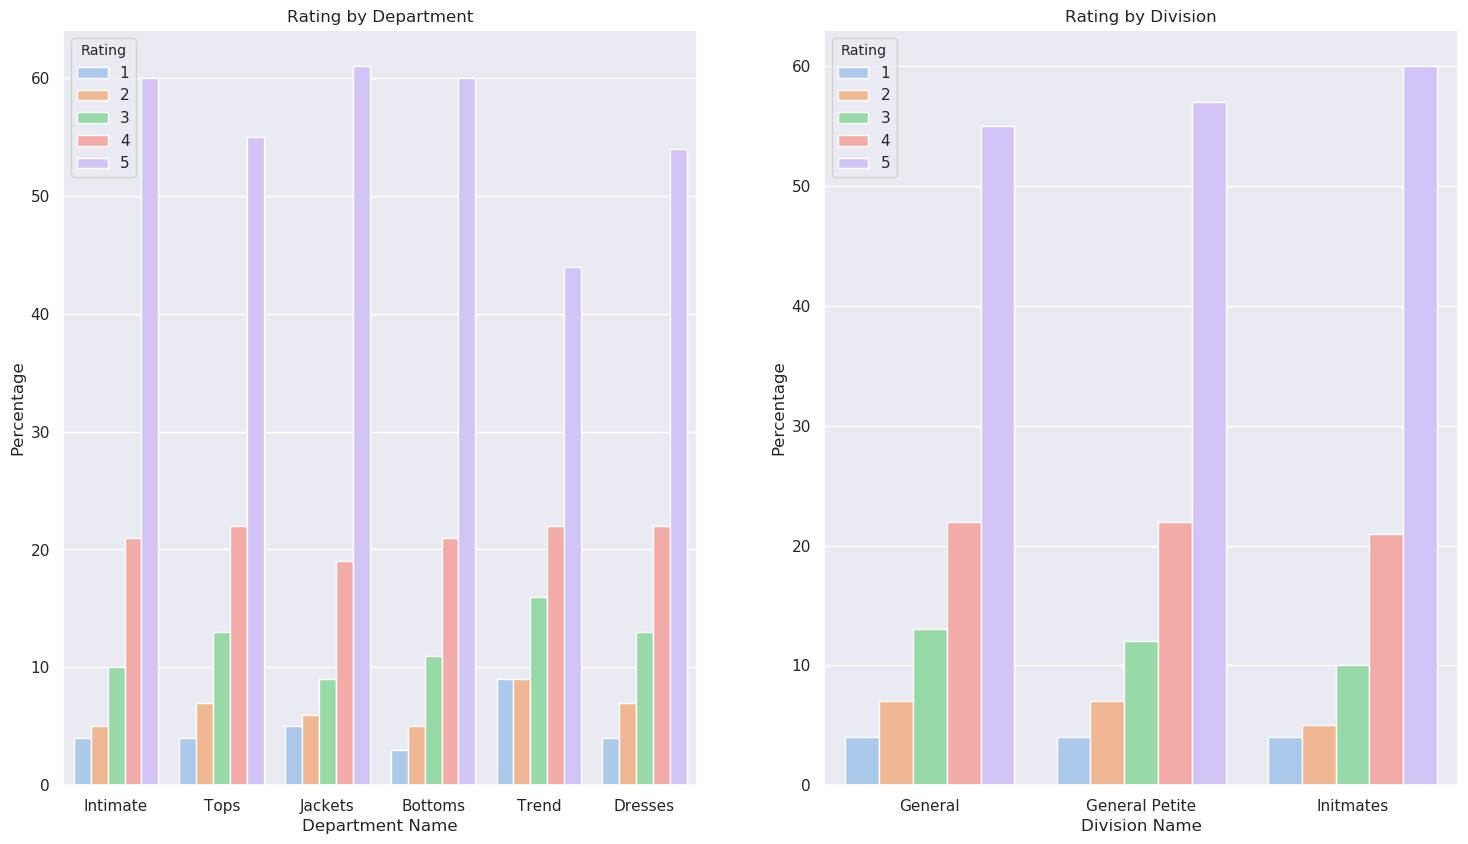

In [36]:
plt.figure(figsize=(18,10),dpi=100)
the_grid = gridspec.GridSpec(1, 2)

sns.set(font_scale=1)
df=(data[['Department Name', 'Rating']]
          .reset_index(drop=True)
          .groupby(['Department Name'])['Rating']
          .value_counts(normalize=True)
          .rename('Percentage').mul(100).round(0)
          .reset_index()
          .sort_values('Rating'))
plt.subplot(the_grid[0],  title='Rating by Department')
sns.barplot(x="Department Name",y="Percentage",hue="Rating",palette=sns.color_palette('pastel'),data=df)

df=(data[['Division Name', 'Rating']]
          .reset_index(drop=True)
          .groupby(['Division Name'])['Rating']
          .value_counts(normalize=True)
          .rename('Percentage').mul(100).round(0)
          .reset_index()
          .sort_values('Rating'))
plt.subplot(the_grid[1],  title='Rating by Division')
sns.barplot(x="Division Name",hue="Rating",y="Percentage",palette=sns.color_palette('pastel'),data=df)

plt.show()

**Plot shows consistency in rating distribution**

## Rating by Recommended IND

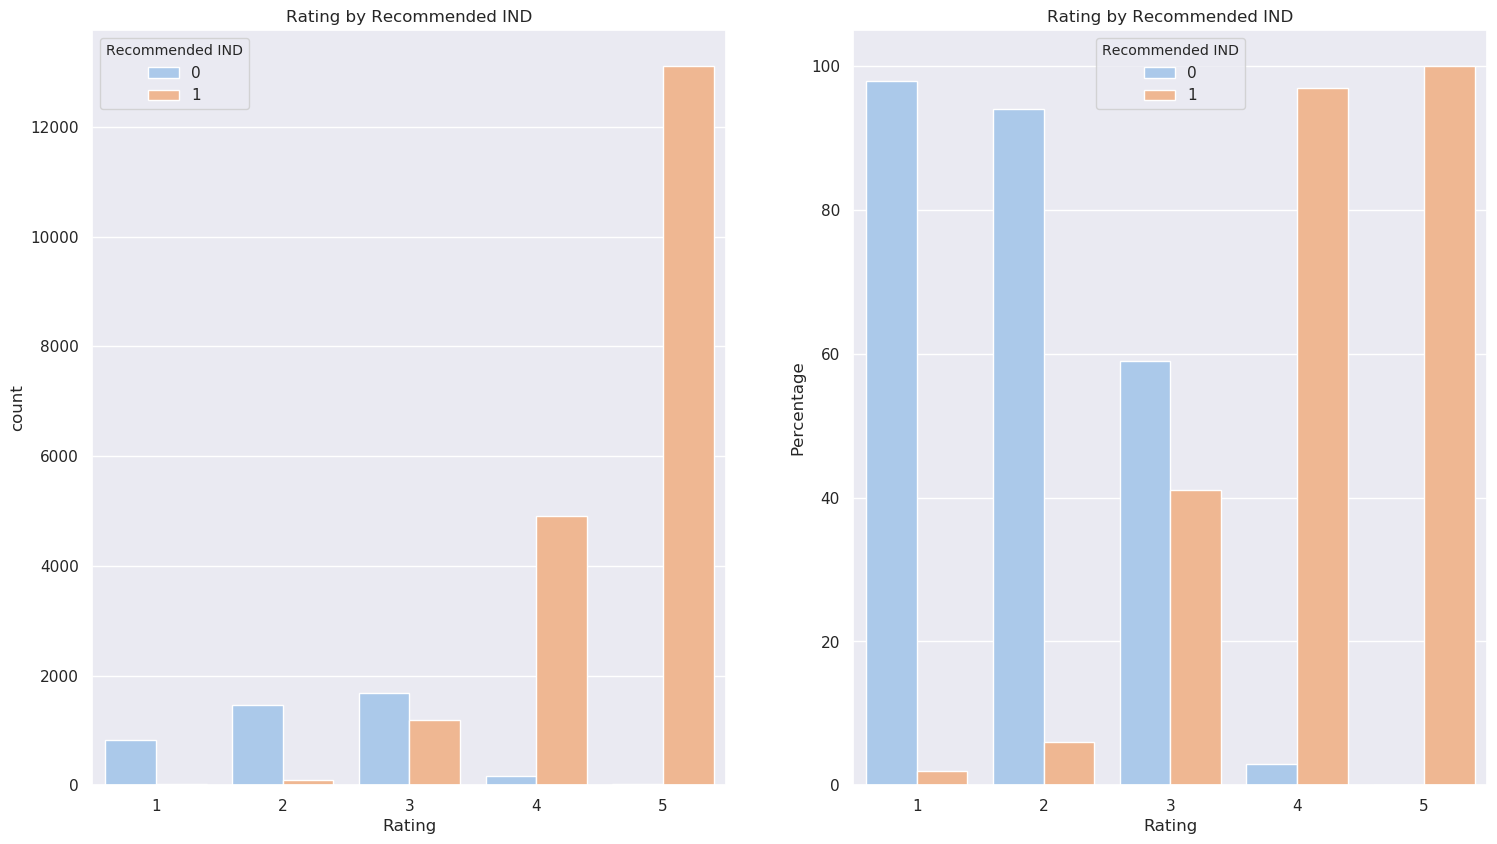

In [37]:
plt.figure(figsize=(18,10),dpi=100)
the_grid = gridspec.GridSpec(1, 2)

sns.set(font_scale=1) 
plt.subplot(the_grid[0],  title='Rating by Recommended IND')
sns.countplot(x=data["Rating"],hue=data["Recommended IND"],palette=sns.color_palette('pastel'))

df=(data[['Rating','Recommended IND']]
          .reset_index(drop=True)
          .groupby(['Rating'])['Recommended IND']
          .value_counts(normalize=True)
          .rename('Percentage').mul(100).round(0)
          .reset_index()
          .sort_values('Recommended IND'))
plt.subplot(the_grid[1],  title='Rating by Recommended IND')
sns.barplot(x="Rating",hue="Recommended IND",y="Percentage",palette=sns.color_palette('pastel'),data=df)

plt.show()

**Plot supports the assumption that a review rating mirrors its recommendation status, i.e. higher rating means recommendation and viceversa**

# Multivariate Analysis

## Average Rating and Recommended IND by Clothing ID

In [38]:
dt = (data.groupby('Clothing ID')[['Rating', 'Recommended IND', 'Age']]
        .aggregate(['count', 'mean']))
dt.columns = ['Count', 'Rating Mean', 'Recommended IND Count',
                'Recommended Mean', 'Age Count', 'Age Mean']
dt.drop(['Recommended IND Count', 'Age Count'], axis=1, inplace=True)

In [39]:
dt.head()

Count  Rating Mean  Recommended Mean   Age Mean
Clothing ID                                                 
0                1          5.0          1.000000  26.000000
1                3          4.0          0.666667  36.666667
2                1          4.0          1.000000  28.000000
3                1          5.0          1.000000  36.000000
4                1          5.0          1.000000  28.000000

**The below plot shows the correlation, if there is any, between the average rating of a product and number of reviews for a product, that is grouped by clothingID. The correlation matrix suggests there is no such correlation between the variables considered, but it did reveal a relatively strong correlation of 0.8 between rating and recommendation. The mentioned correlation coefficient further substantiates the assumption on connection between rating and recommendation.**

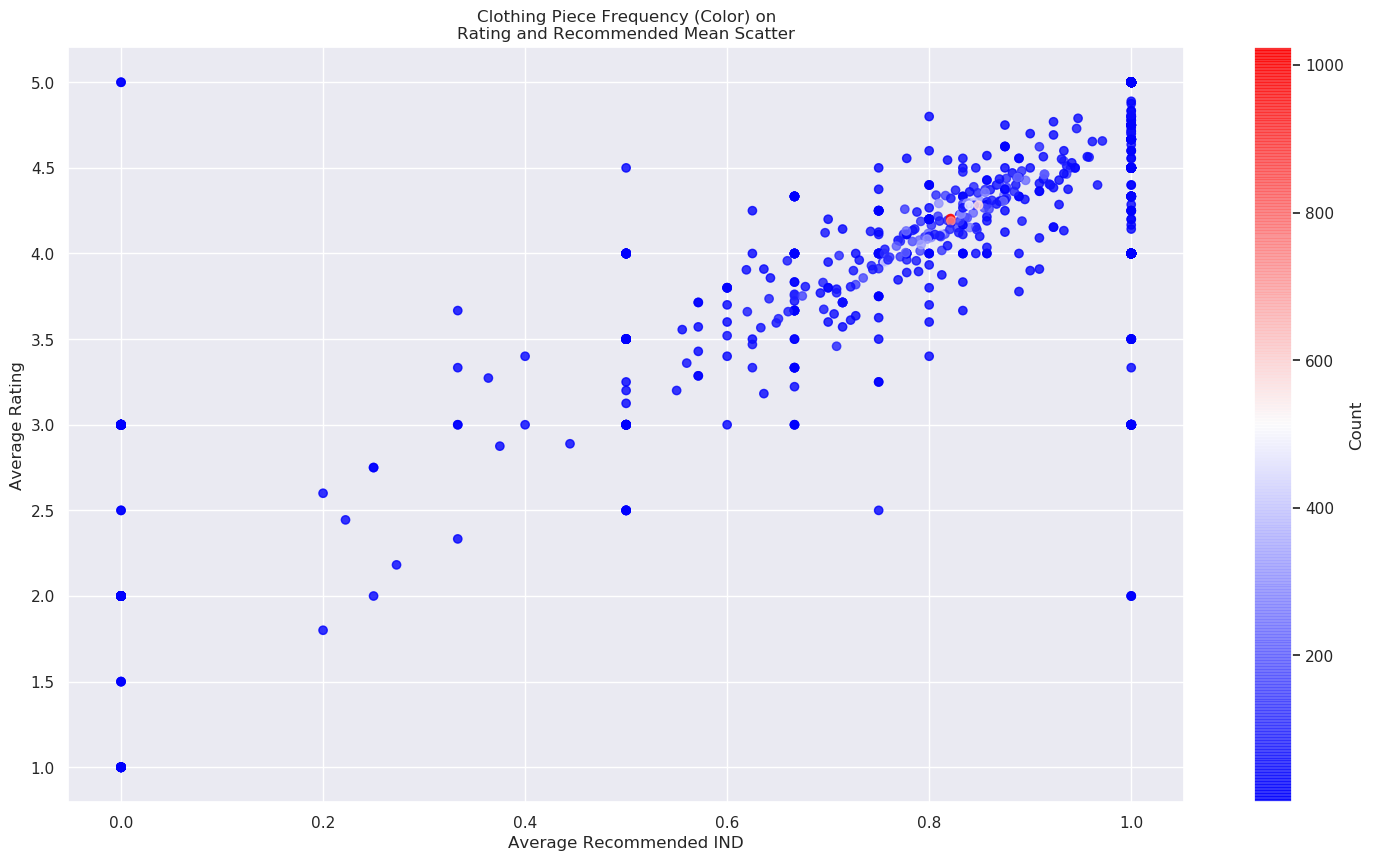

In [40]:
plt.figure(figsize=(18,10),dpi=100)
plt.scatter(dt['Recommended Mean'], dt['Rating Mean'],
            alpha=.8, c=dt["Count"], cmap='bwr')
cbar = plt.colorbar() 
cbar.set_label('Count', rotation=90)
plt.xlabel('Average Recommended IND')
plt.ylabel('Average Rating')
plt.title('Clothing Piece Frequency (Color) on\nRating and Recommended Mean Scatter')
plt.show()

## Average Rating and Recommended IND by Class Name

In [41]:
dp = (data.groupby('Class Name')[['Rating', 'Recommended IND', 'Age']]
        .aggregate(['count', 'mean']))
dp.columns = ['Count', 'Rating Mean', 'Recommended Likelihood Count',
                'Recommended Likelihood', 'Age Count', 'Age Mean']
dp.drop(['Recommended Likelihood Count', 'Age Count'], axis=1, inplace=True)

In [42]:
dp.head()

Count  Rating Mean  Recommended Likelihood   Age Mean
Class Name                                                           
Blouses          3097     4.154020                0.810139  44.252502
Casual bottoms      2     4.500000                1.000000  26.500000
Chemises            1     4.000000                1.000000  38.000000
Dresses          6319     4.150815                0.808197  42.114892
Fine gauge       1100     4.260909                0.837273  44.730909

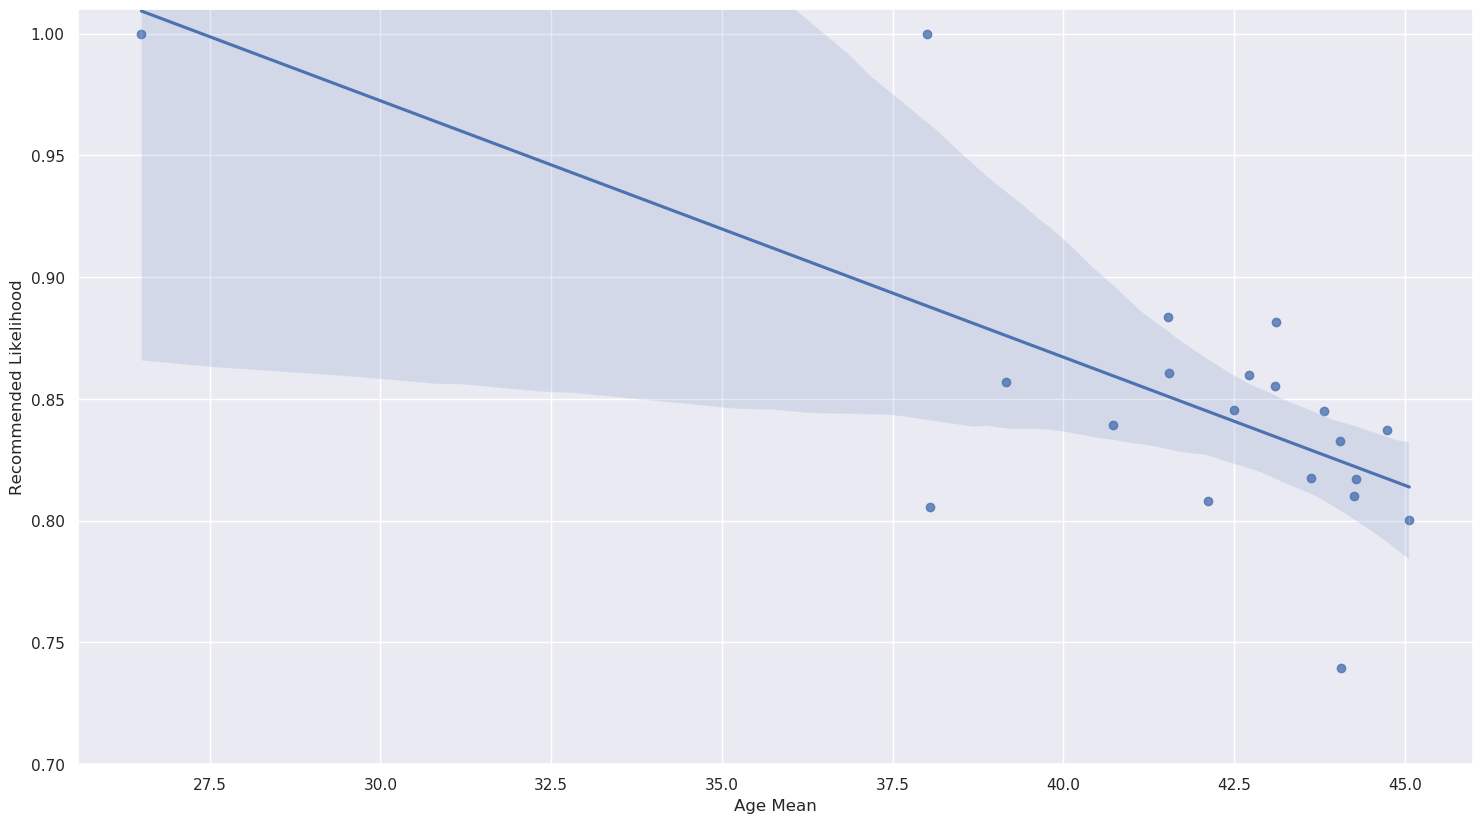

In [43]:
plt.figure(figsize=(18,10),dpi=100)
sns.regplot(y='Recommended Likelihood', x='Age Mean', data=dp, color='b')
plt.ylim(.7, 1.01)
plt.show()

## Correlation Between Features

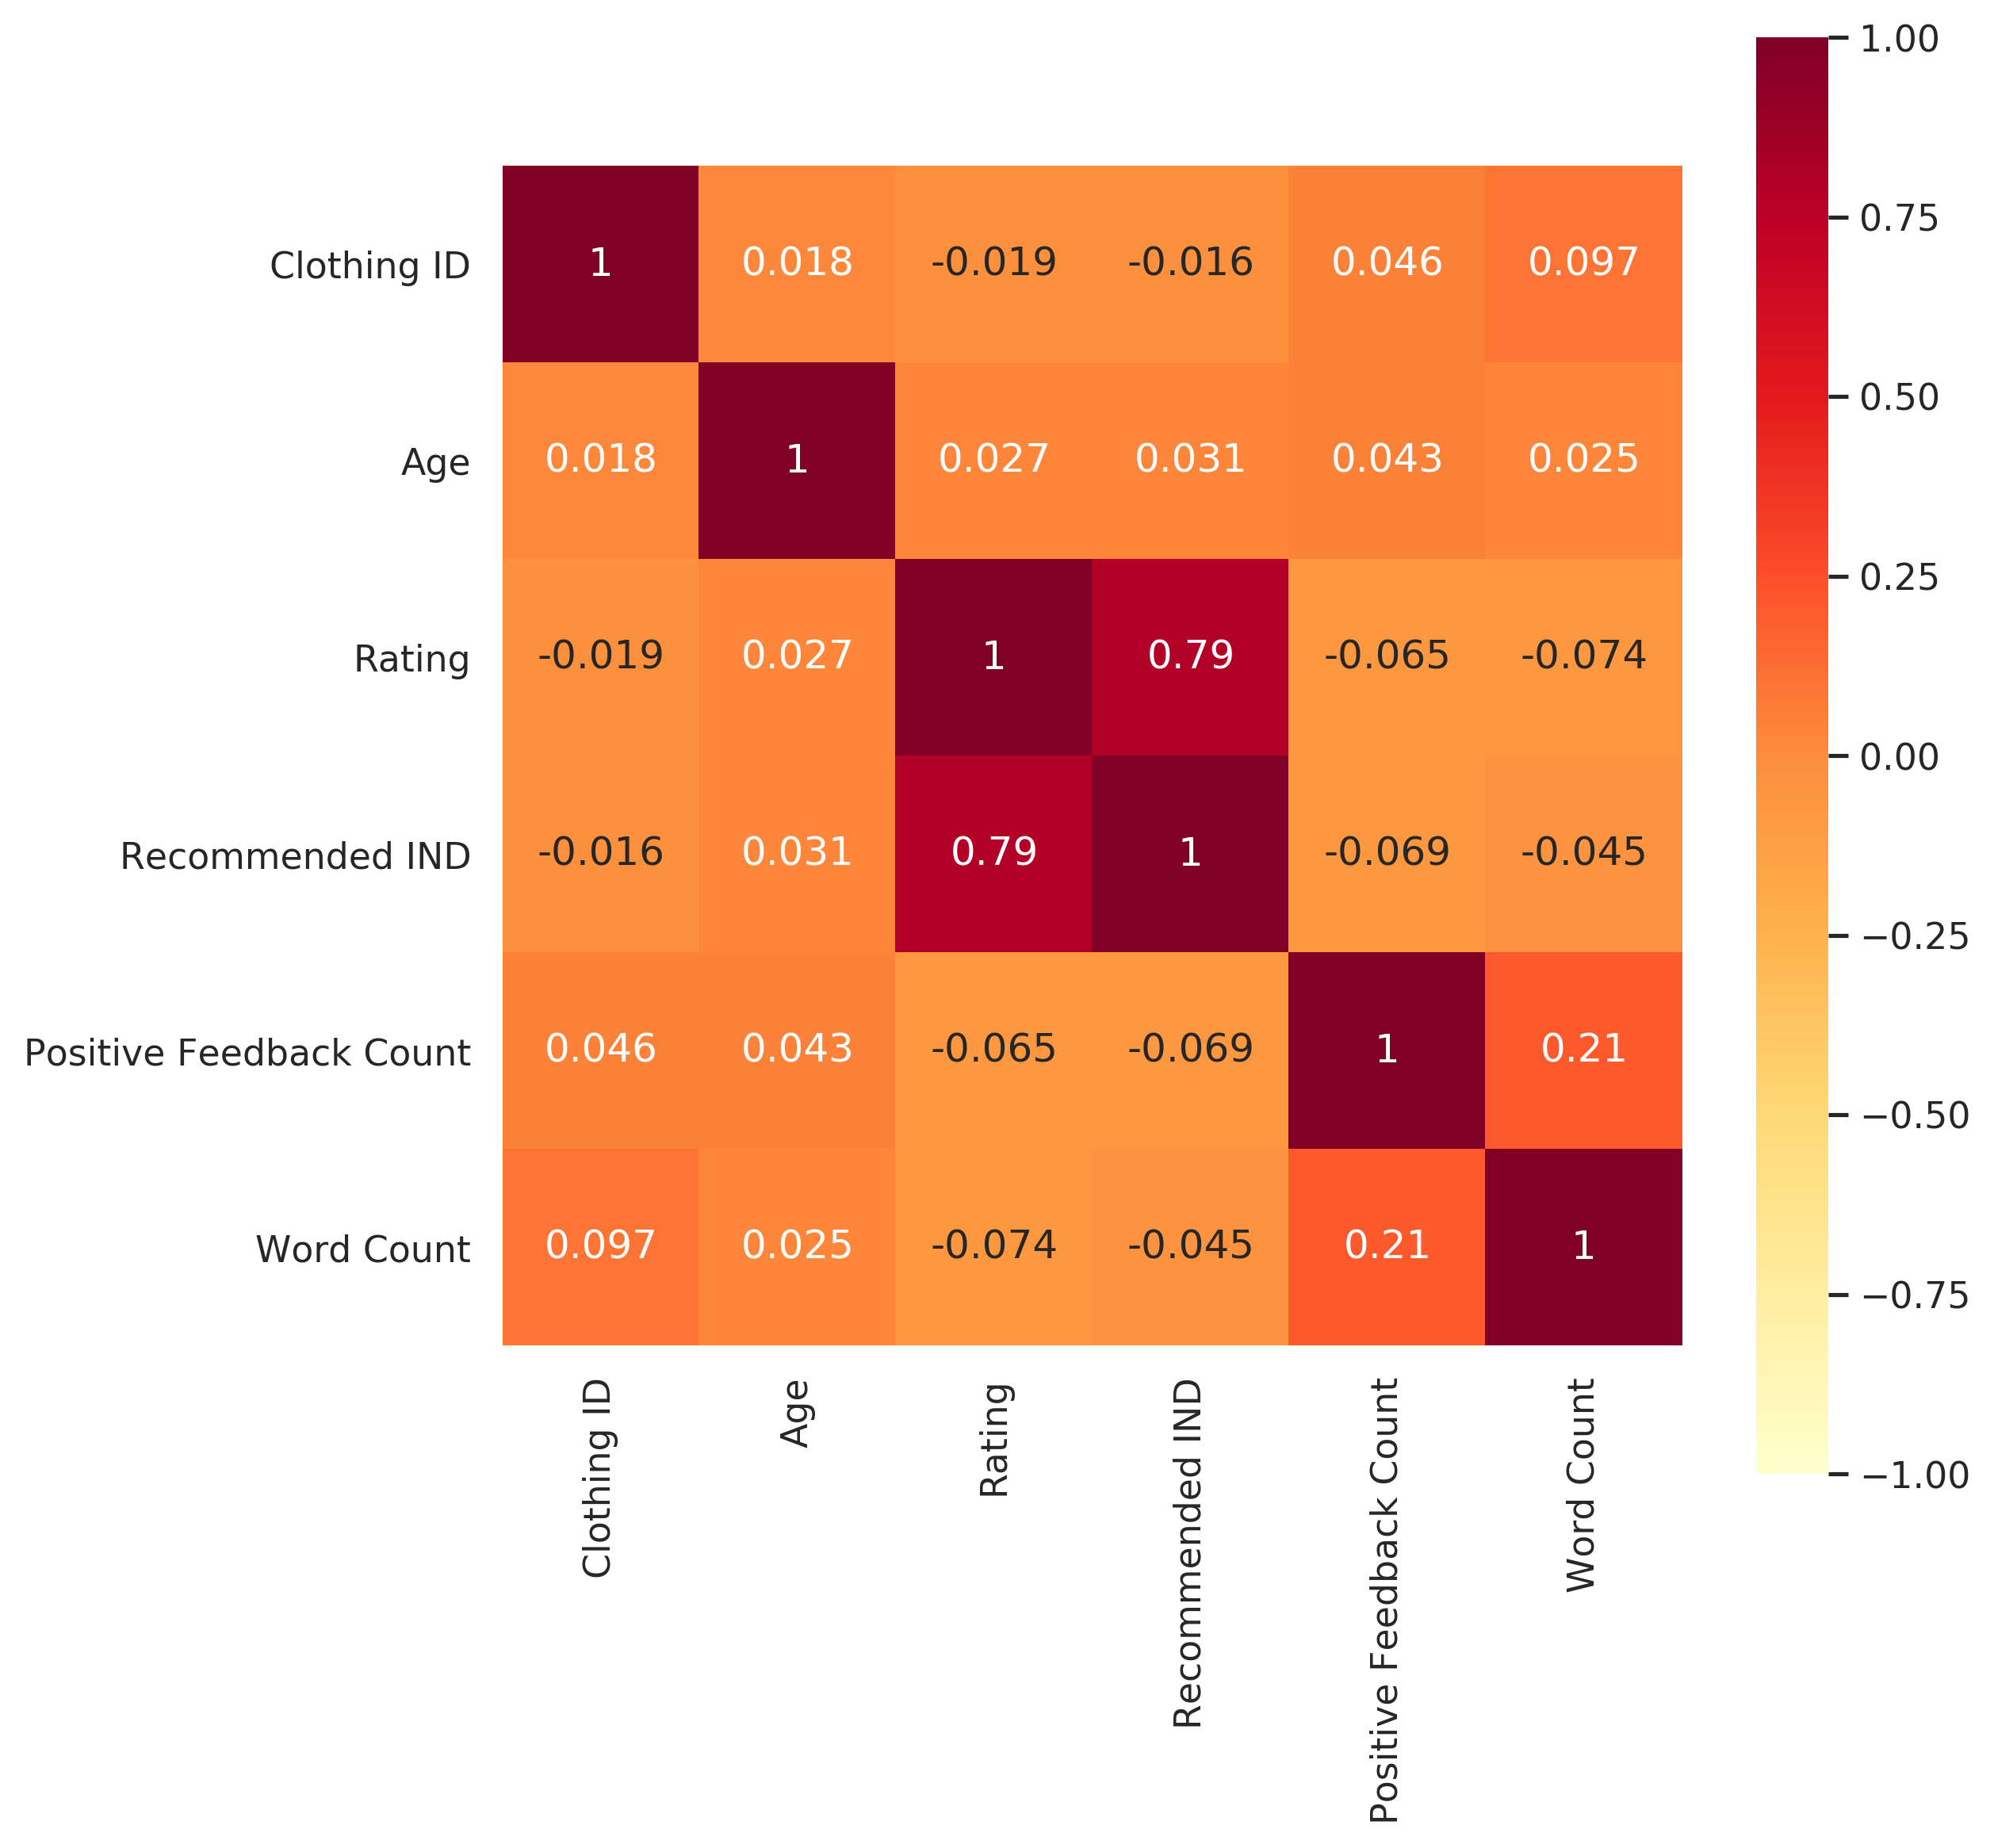

In [44]:
plt.figure(figsize = (8,8),dpi=300)
sns.heatmap(data.corr(), vmin=-1, vmax=1, center=0,
            square=True, annot = True, cmap = 'YlOrRd')
plt.show()

# Data Cleaning and Text Preprocessing

In [45]:
df = data.copy()

In [46]:
df = df.dropna(subset=['Review Text'])

In [47]:
# Text Preprocessing
# nltk.download('stopwords') --download stopwords only if not found
# pip install spacy
# import sys
#!{sys.executable} -m spacy download en
# nltk.download('punkt')

stop = set(stopwords.words('english'))
stop.add("i'm")
snb = SnowballStemmer('english')

def cleanpunc(sentence):
    sentence = re.sub("[?;!_#-]","",sentence)
    sentence = re.sub("[.,)(\/:<>]","",sentence)
    sentence = re.sub("[0-9]","",sentence)
    cleaned = re.sub("[\[\]]","",sentence)  
    return cleaned

## NLTK

In [48]:
from nltk.tokenize import word_tokenize
import spacy
nlp = spacy.load("en")

df['Cleaned_Text'] = df['Review Text']
clean = []

for sent in df['Review Text']:
    sentence = cleanpunc(sent)
    wordtokens = sentence.split()
    updatelist=[]
    for w in wordtokens:
        if((w.lower() not in stop)&(len(w)>2)):
            updatelist.append(w.lower())
    sentence = " ".join(updatelist)
    sentence = re.sub("[']",'',sentence)
    sentence = re.sub('["]','',sentence)
    updatelist = []
    doc = nlp(sentence)
    updatelist.append(" ".join([token.lemma_ for token in doc]))
    sentence = "".join(updatelist)
    clean.append(sentence) 

In [49]:
df['Cleaned_Text'] = clean

In [50]:
df.head()

Clothing ID  Age                    Title  \
0          767   33                      NaN   
1         1080   34                      NaN   
2         1077   60  Some major design flaws   
3         1049   50         My favorite buy!   
4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  \
0                        0       Initmates        Intimate  Intimates   
1                        4         General         Dresses    Dresses   
2                        0         General         Dresses    Dresses   
3                        0  General Petite         Bottoms      Pants   
4                        6         General            Tops    Blouses   

  Rating_Class  Word Count                                       Cleaned_Text  
0         Good           8        absolutely wonderful silky sexy comfortable  
1         Good          62  love dress sooo pretty happen find store glad ...  
2          Bad          98  high hope dress really want work initially ord...  
3         Good          22  love love love jumpsuit fun flirty fabulous ev...  
4         Good          36  shirt flattering due adjustable front tie perf...

In [51]:
for sm in df[df["Rating_Class"]=="Good"]['Review Text'][:5]:
    print(sm)
    print("")

Absolutely wonderful - silky and sexy and comfortable

Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.

I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!

This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!

I aded this in my basket at hte last mintue to see what it would look like in person. (store pick up). i went with teh darkler color only because i am so pale :-) hte color is really gorgeous, and turns out it mathced everythiing i was trying on with it prefectly. it is a little baggy on me and hte xs is hte msallet si

In [52]:
for sm in df[df["Rating_Class"]=="Good"]['Cleaned_Text'][:5]:
    print(sm)
    print("")

absolutely wonderful silky sexy comfortable

love dress sooo pretty happen find store glad never would order online petite buy petite love length hit little knee would definitely true midi someone truly petite

love love love jumpsuit fun flirty fabulous every time wear get nothing great compliment

shirt flattering due adjustable front tie perfect length wear legging sleeveless pair well cardigan love shirt

ade basket hte last mintue see would look like person store pick go teh darkl color pale hte color really gorgeous turn mathce everythie try prefectly little baggy hte hte msallet size bummer petite decide jkeep though say matvehd everything ejan pant skirt waas try keep oop



## Word Cloud of Highly-rated Reviews

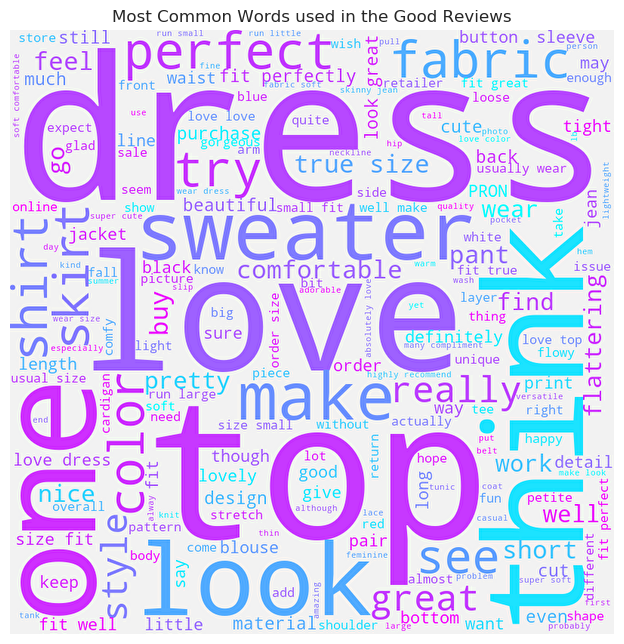

In [53]:
plt.figure(figsize=(10,8),dpi=100)
wc = WordCloud(width=800, height=800, margin=0, background_color="#f2f2f2" , 
                colormap=plt.get_cmap('cool') ,
                min_font_size = 10, max_font_size = 500).generate(' '.join(df[df['Rating_Class']=="Good"]['Cleaned_Text']))
plt.imshow(wc, interpolation='sinc')
plt.title("Most Common Words used in the Good Reviews")
plt.axis("off")
plt.show()

## Word Cloud of Low-rated Reviews

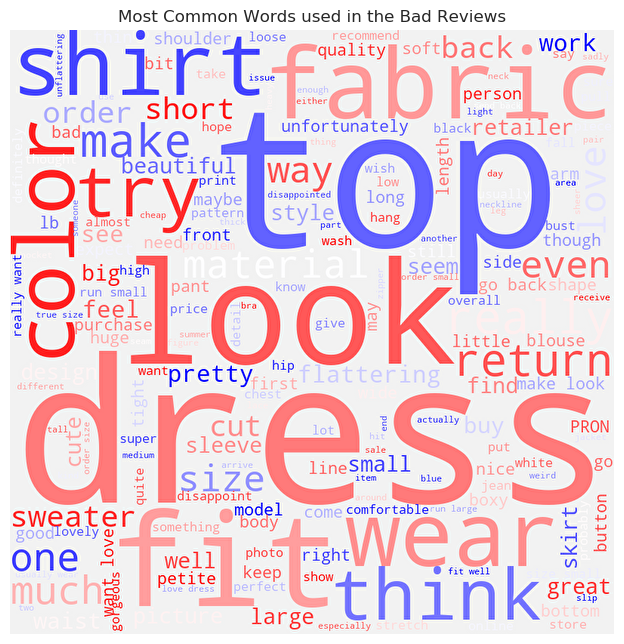

In [54]:
plt.figure(figsize=(10,8),dpi=100)
wc = WordCloud(width=800, height=800, margin=0, background_color="#f2f2f2" , 
                colormap=plt.get_cmap('bwr') ,
                min_font_size = 10, max_font_size = 500).generate(' '.join(df[df['Rating_Class']=="Bad"]['Cleaned_Text']))
plt.imshow(wc, interpolation='sinc')
plt.title("Most Common Words used in the Bad Reviews")
plt.axis("off")
plt.show()

## Most Frequent Words in Highly-rated Reviews 

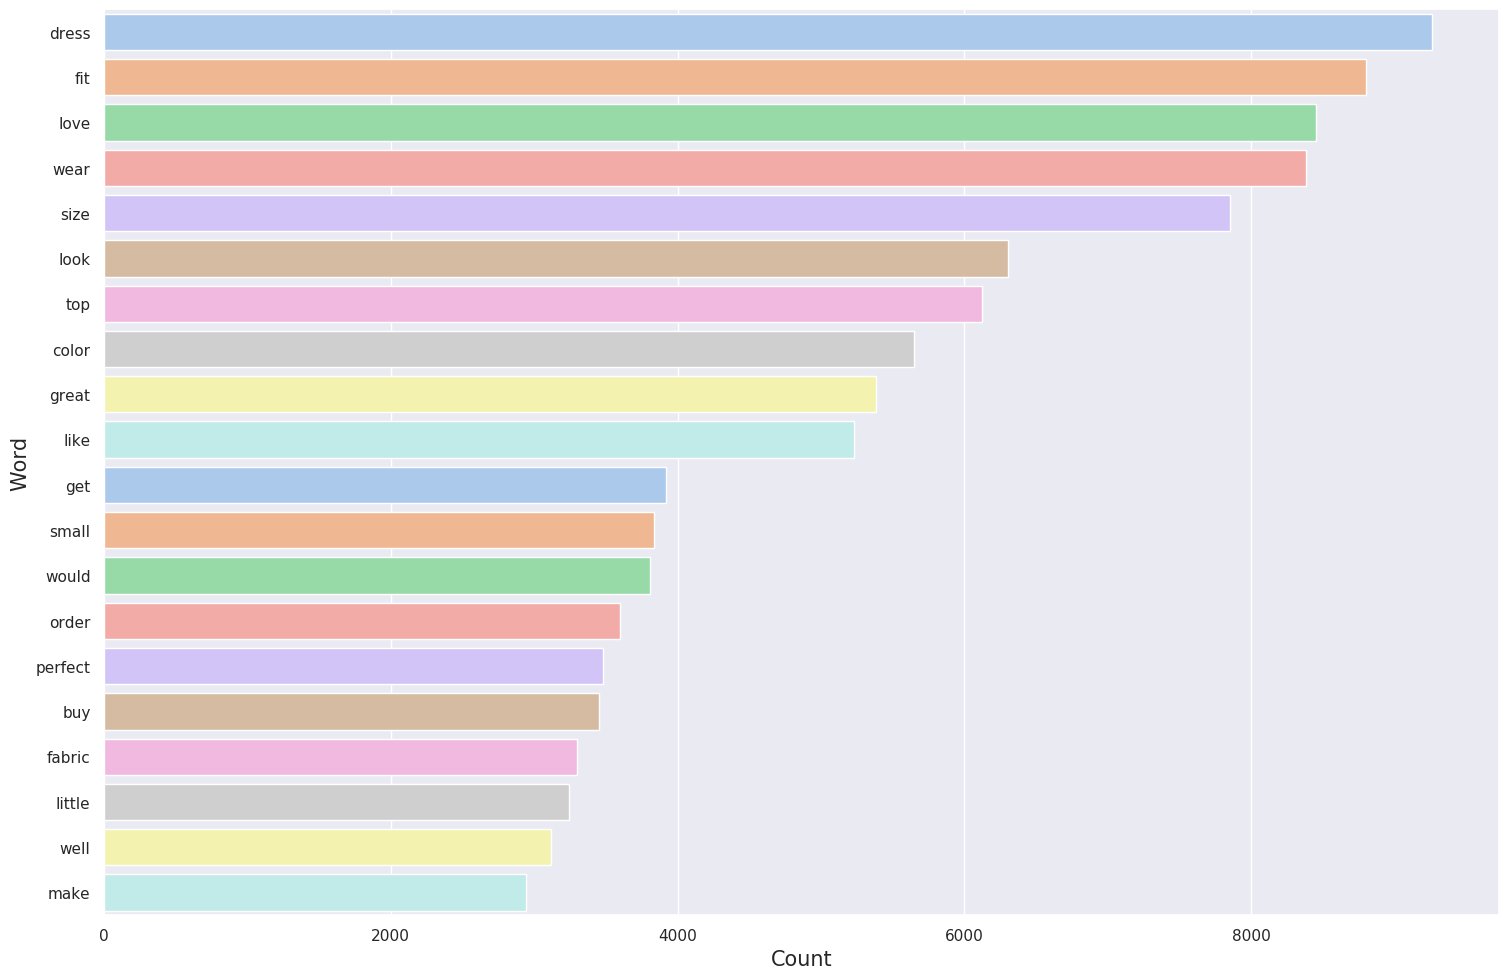

In [55]:
from nltk.probability import FreqDist
Good_Words = "  ".join(df[df['Rating_Class']=="Good"]['Cleaned_Text'])
fd = FreqDist(Good_Words.split())
plt.figure(figsize=(18,12),dpi=100)
sns.barplot(data=pd.DataFrame(fd.most_common(20),columns=['Word','Count']),y="Word",x="Count",orient="h",palette=sns.color_palette('pastel'))
plt.xlabel("Count",fontsize=15)
plt.ylabel("Word",fontsize=15)
plt.show()

## Most Frequent Words in Low-rated Reviews 

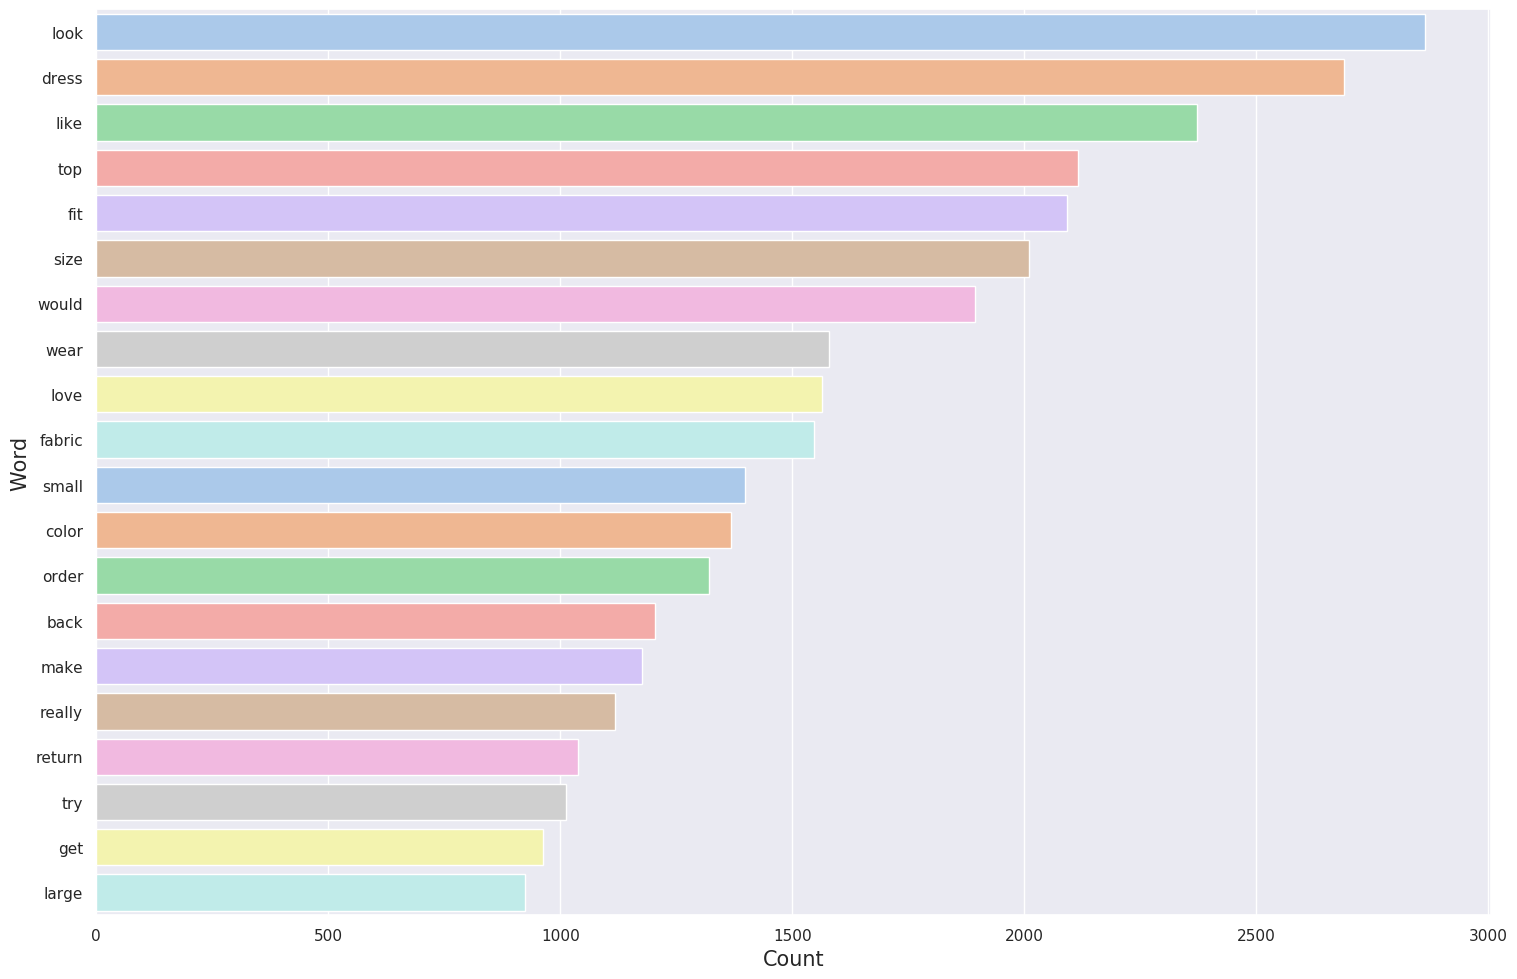

In [56]:
from nltk.probability import FreqDist
Bad_Words = ' '.join(df[df['Rating_Class']=="Bad"]['Cleaned_Text'])
fd = FreqDist(Bad_Words.split())
plt.figure(figsize=(18,12),dpi=100)
sns.barplot(data=pd.DataFrame(fd.most_common(20),columns=['Word','Count']),y="Word",x="Count",orient="h",palette=sns.color_palette('pastel'))
plt.xlabel("Count",fontsize=15)
plt.ylabel("Word",fontsize=15)
plt.show()

In [57]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')
SIA = SentimentIntensityAnalyzer()

df['Polarity Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['compound'])
df['Neutral Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neu'])
df['Negative Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neg'])
df['Positive Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['pos'])

df['Sentiment']=0
df.loc[df['Polarity Score']>0,'Sentiment']=1 #Positive
df.loc[df['Polarity Score']==0,'Sentiment']=0 #Neutral
df.loc[df['Polarity Score']<0,'Sentiment']=-1 #Negative

In [58]:
df.head()

Clothing ID  Age                    Title  \
0          767   33                      NaN   
1         1080   34                      NaN   
2         1077   60  Some major design flaws   
3         1049   50         My favorite buy!   
4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  \
0                        0       Initmates        Intimate  Intimates   
1                        4         General         Dresses    Dresses   
2                        0         General         Dresses    Dresses   
3                        0  General Petite         Bottoms      Pants   
4                        6         General            Tops    Blouses   

  Rating_Class  Word Count                                       Cleaned_Text  \
0         Good           8        absolutely wonderful silky sexy comfortable   
1         Good          62  love dress sooo pretty happen find store glad ...   
2          Bad          98  high hope dress really want work initially ord...   
3         Good          22  love love love jumpsuit fun flirty fabulous ev...   
4         Good          36  shirt flattering due adjustable front tie perf...   

   Polarity Score  Neutral Score  Negative Score  Positive Score  Sentiment  
0          0.8932          0.272           0.000           0.728          1  
1          0.9729          0.664           0.000           0.336          1  
2          0.9427          0.792           0.027           0.181          1  
3          0.5727          0.340           0.226           0.434          1  
4          0.9291          0.700           0.000           0.300          1

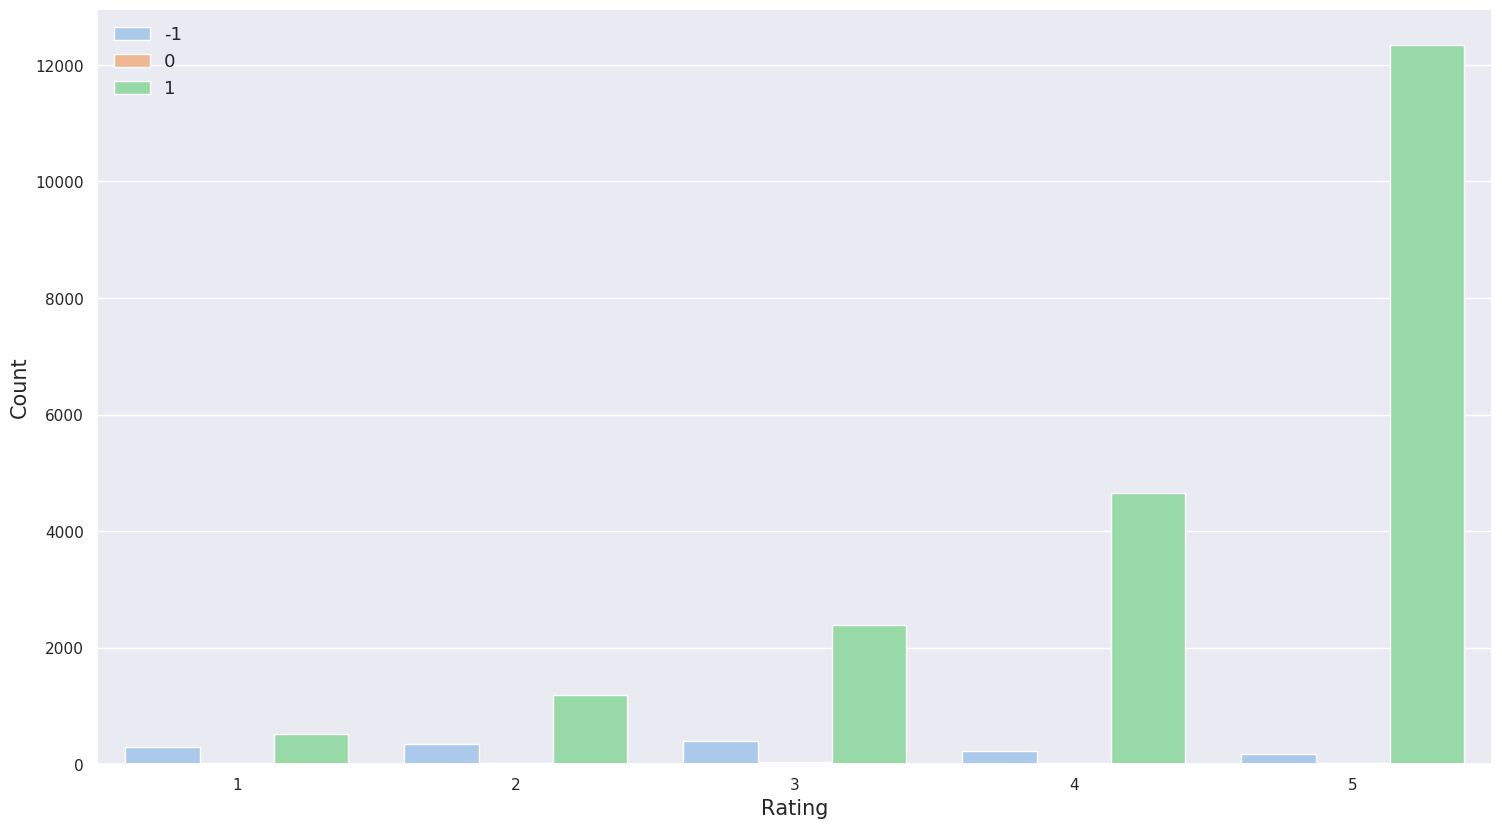

In [59]:
plt.figure(figsize=(18,10),dpi=100)
sns.countplot(x="Rating",hue="Sentiment",data=df,palette=sns.color_palette("pastel"))
plt.legend(frameon=False,fontsize=13)
plt.xlabel("Rating",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.show()

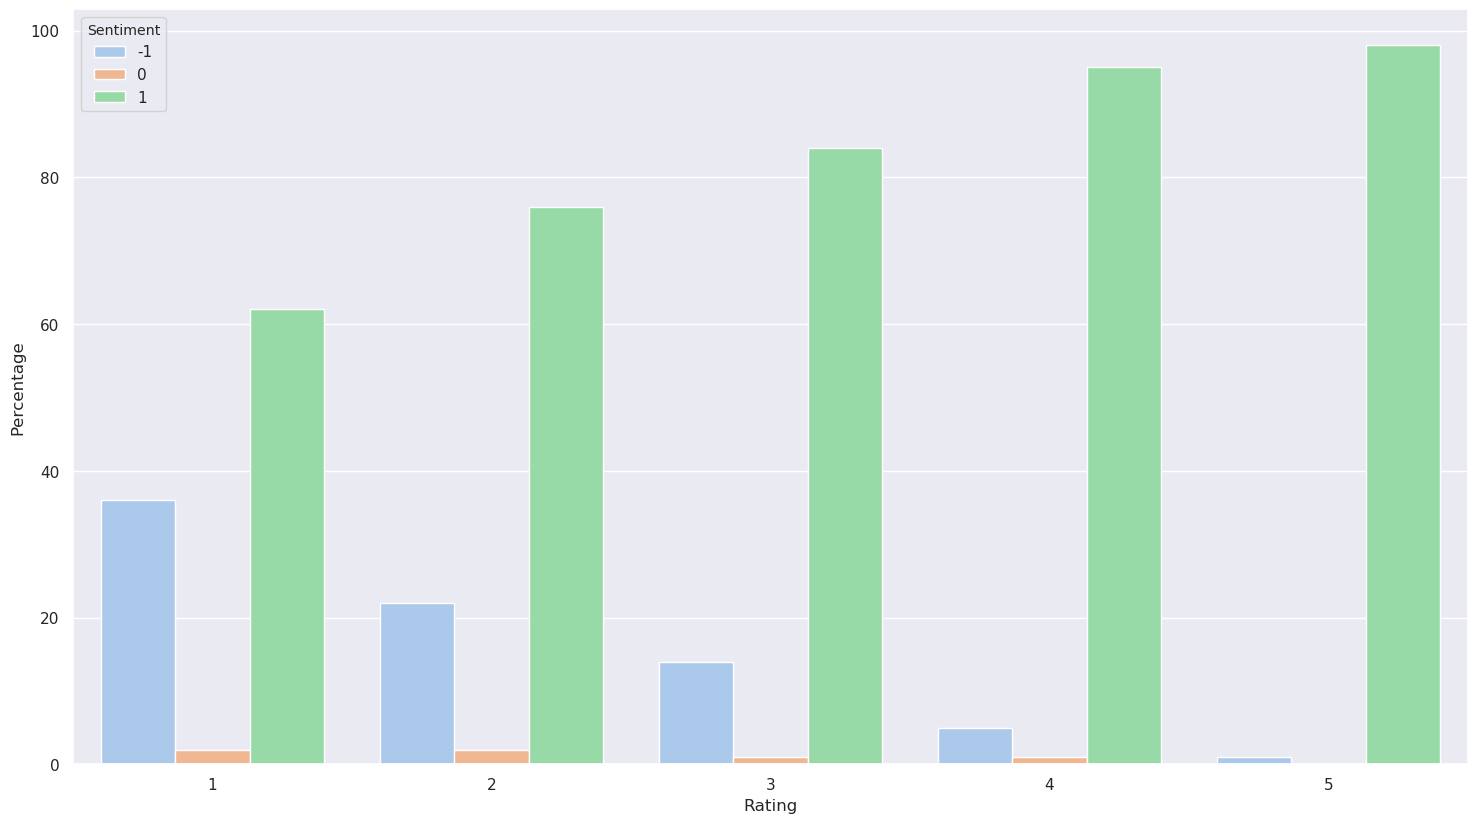

In [60]:
plt.figure(figsize=(18,10),dpi=100)

sns.set(font_scale=1)
dsf=(df[['Rating','Sentiment']]
          .reset_index(drop=True)
          .groupby(['Rating'])['Sentiment']
          .value_counts(normalize=True)
          .rename('Percentage').mul(100).round(0)
          .reset_index()
          .sort_values('Sentiment'))

sns.barplot(x="Rating",y="Percentage",hue="Sentiment",palette=sns.color_palette('pastel'),data=dsf)
plt.show()

**Like the distribution of rating, most reviews have a positive sentiment. Unlike the distribution of rating, there is a lower occurrence of neutral rating is lower in proportion to the occurrence of medium ranged ratings.**

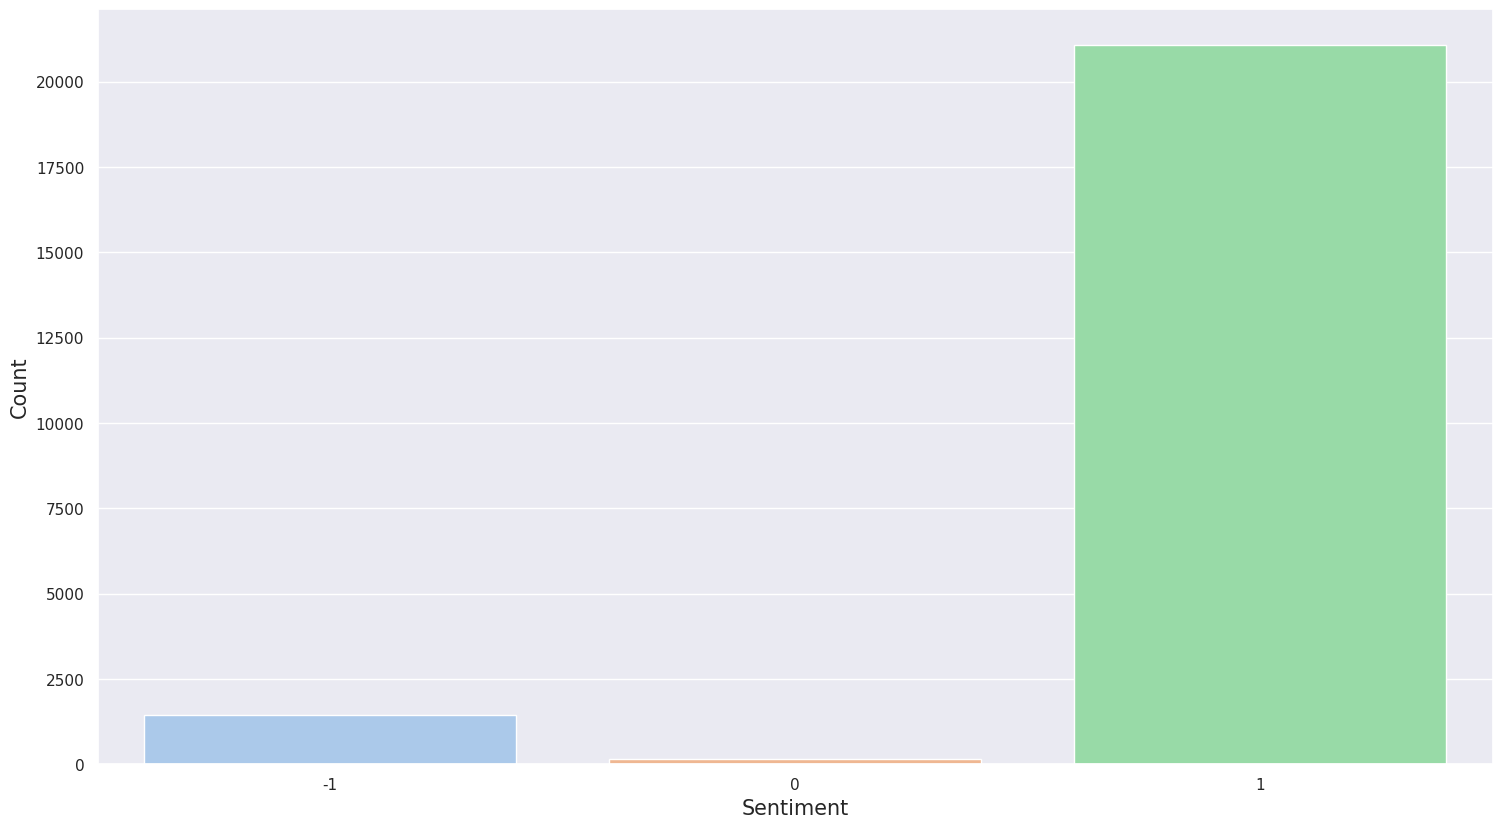

In [61]:
plt.figure(figsize=(18,10),dpi=100)
sns.countplot(x="Sentiment",data=df,palette=sns.color_palette("pastel"))
plt.xlabel("Sentiment",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.show()

In [62]:
from textblob import TextBlob
df['TBSentiment'] = df['Cleaned_Text'].map(lambda x: TextBlob(x).sentiment.polarity)

In [63]:
df['TBSentimentSubj'] = df['Cleaned_Text'].map(lambda x: TextBlob(x).sentiment.subjectivity)

In [64]:
df.head()

Clothing ID  Age                    Title  \
0          767   33                      NaN   
1         1080   34                      NaN   
2         1077   60  Some major design flaws   
3         1049   50         My favorite buy!   
4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  \
0                        0       Initmates        Intimate  Intimates   
1                        4         General         Dresses    Dresses   
2                        0         General         Dresses    Dresses   
3                        0  General Petite         Bottoms      Pants   
4                        6         General            Tops    Blouses   

  Rating_Class  Word Count                                       Cleaned_Text  \
0         Good           8        absolutely wonderful silky sexy comfortable   
1         Good          62  love dress sooo pretty happen find store glad ...   
2          Bad          98  high hope dress really want work initially ord...   
3         Good          22  love love love jumpsuit fun flirty fabulous ev...   
4         Good          36  shirt flattering due adjustable front tie perf...   

   Polarity Score  Neutral Score  Negative Score  Positive Score  Sentiment  \
0          0.8932          0.272           0.000           0.728          1   
1          0.9729          0.664           0.000           0.336          1   
2          0.9427          0.792           0.027           0.181          1   
3          0.5727          0.340           0.226           0.434          1   
4          0.9291          0.700           0.000           0.300          1   

   TBSentiment  TBSentimentSubj  
0     0.633333         0.933333  
1     0.318750         0.725000  
2     0.062409         0.338526  
3     0.500000         0.625000  
4     0.458333         0.658333

In [65]:
df['Title'].fillna(" ",inplace=True)
df['Title'].isnull().sum()

0

In [66]:
df['TBSentimentTitle'] = df['Title'].map(lambda x: TextBlob(x).sentiment.polarity)

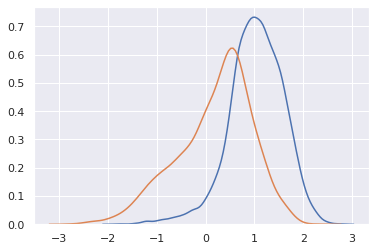

In [67]:
sns.kdeplot(df[df["Rating_Class"]=="Good"]['TBSentimentTitle'] + df[df["Rating_Class"]=="Good"]['TBSentiment'] + (df[df["Rating_Class"]=="Good"]['TBSentimentSubj']) + df[df["Rating_Class"]=="Good"]['Polarity Score'] - df[df["Rating_Class"]=="Good"]['Positive Score'] - df[df["Rating_Class"]=="Good"]['Negative Score'] - df[df["Rating_Class"]=="Good"]['Neutral Score'])
sns.kdeplot(df[df["Rating_Class"]=="Bad"]['TBSentimentTitle'] + df[df["Rating_Class"]=="Bad"]['TBSentiment'] + (df[df["Rating_Class"]=="Bad"]['TBSentimentSubj']) + df[df["Rating_Class"]=="Bad"]['Polarity Score'] - df[df["Rating_Class"]=="Bad"]['Positive Score'] - df[df["Rating_Class"]=="Bad"]['Negative Score'] - df[df["Rating_Class"]=="Bad"]['Neutral Score'])

In [68]:
df.corr()

Clothing ID       Age    Rating  Recommended IND  \
Clothing ID                 1.000000  0.017688 -0.018454        -0.014874   
Age                         0.017688  1.000000  0.029962         0.034208   
Rating                     -0.018454  0.029962  1.000000         0.792568   
Recommended IND            -0.014874  0.034208  0.792568         1.000000   
Positive Feedback Count     0.044902  0.040850 -0.060984        -0.065923   
Word Count                  0.094333  0.013352 -0.057609        -0.029756   
Polarity Score              0.004251 -0.000609  0.465807         0.427276   
Neutral Score               0.049098  0.004591 -0.257204        -0.196970   
Negative Score              0.019276 -0.012089 -0.404248        -0.378926   
Positive Score             -0.053487  0.000349  0.396078         0.329859   
Sentiment                  -0.001663 -0.000459  0.340408         0.321646   
TBSentiment                 0.003666  0.007268  0.352661         0.288826   
TBSentimentSubj             0.009221 -0.009439  0.146432         0.116965   
TBSentimentTitle            0.017829  0.004308  0.375281         0.331381   

                         Positive Feedback Count  Word Count  Polarity Score  \
Clothing ID                             0.044902    0.094333        0.004251   
Age                                     0.040850    0.013352       -0.000609   
Rating                                 -0.060984   -0.057609        0.465807   
Recommended IND                        -0.065923   -0.029756        0.427276   
Positive Feedback Count                 1.000000    0.187745       -0.023998   
Word Count                              0.187745    1.000000        0.107647   
Polarity Score                         -0.023998    0.107647        1.000000   
Neutral Score                           0.120491    0.474156       -0.310557   
Negative Score                          0.026493    0.061522       -0.633859   
Positive Score                         -0.123265   -0.468705        0.533995   
Sentiment                              -0.026563    0.023881        0.837606   
TBSentiment                            -0.082697   -0.288113        0.410495   
TBSentimentSubj                        -0.063642   -0.239947        0.176529   
TBSentimentTitle                       -0.038912   -0.005227        0.230353   

                         Neutral Score  Negative Score  Positive Score  \
Clothing ID                   0.049098        0.019276       -0.053487   
Age                           0.004591       -0.012089        0.000349   
Rating                       -0.257204       -0.404248        0.396078   
Recommended IND              -0.196970       -0.378926        0.329859   
Positive Feedback Count       0.120491        0.026493       -0.123265   
Word Count                    0.474156        0.061522       -0.468705   
Polarity Score               -0.310557       -0.633859        0.533995   
Neutral Score                 1.000000       -0.038661       -0.924086   
Negative Score               -0.038661        1.000000       -0.346161   
Positive Score               -0.924086       -0.346161        1.000000   
Sentiment                    -0.156881       -0.549381        0.357414   
TBSentiment                  -0.506643       -0.300184        0.590507   
TBSentimentSubj              -0.408062       -0.040045        0.398417   
TBSentimentTitle             -0.114825       -0.180063        0.176678   

                         Sentiment  TBSentiment  TBSentimentSubj  \
Clothing ID              -0.001663     0.003666         0.009221   
Age                      -0.000459     0.007268        -0.009439   
Rating                    0.340408     0.352661         0.146432   
Recommended IND           0.321646     0.288826         0.116965   
Positive Feedback Count  -0.026563    -0.082697        -0.063642   
Word Count                0.023881    -0.288113        -0.239947   
Polarity Score            0.837606     0.410495         0.176529   
Neutral Score

# TFIDF Vector

In [69]:
Words = "  ".join(df['Cleaned_Text'])
print("Total Words in Reviews :",len(Words.split()))
fd = FreqDist(Words.split())
dtf = pd.DataFrame(fd.most_common(),columns=['Word','Count'])

Total Words in Reviews : 633105


In [70]:
print("Reducing Overfitting by choosing top 5200 Words from",len(dtf),"Words")

Reducing Overfitting by choosing top 5200 Words from 15855 Words


In [71]:
stp = dtf[dtf["Count"]<3]['Word'].tolist()
len(stp)

10634

In [72]:
vect = TfidfVectorizer(stop_words=stp)
x = vect.fit_transform(df['Cleaned_Text'].tolist())
print("Actual Length of words used by TFIDF :",len(vect.get_feature_names()))
print(type(x))
print("Shape of TFIDF Vector :",x.get_shape())

/home/datascientist/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['akemi', 'amp', 'ampampampamp', 'ampampampampm', 'ampampampampquot', 'ampampampampt', 'ampampampquot', 'ampampampt', 'ampampll', 'ampampm', 'ampamps', 'ampampt', 'ampd', 'ampquot', 'ampquotno', 'ampt', 'aprã', 'bc', 'booty', 'breasts', 'can', 'chest', 'clingy', 'cloth', 'color', 'cup', 'dd', 'degree', 'didn', 'don', 'down', 'ed', 'elastic', 'especially', 'forgiving', 'good', 'im', 'is', 'it', 'kin', 'lb', 'lbs', 'll', 'out', 'pi', 'plus', 'poly', 'probably', 'pure', 'quot', 'quotdrape', 'quoti', 'quotsky', 'scratches', 'ship', 'sski', 'stone', 'sure', 'that', 'thin', 'tight', 'too', 'up', 've', 'waist', 'weightless', 'wool'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Actual Length of words used by TFIDF : 5228
<class 'scipy.sparse.csr.csr_matrix'>
Shape of TFIDF Vector : (22641, 5228)


In [73]:
import scipy
from scipy.sparse import hstack
x = hstack((x,scipy.sparse.csr.csr_matrix(df['Recommended IND']).T))

In [74]:
x = x.toarray()
x.shape

(22641, 5229)

In [75]:
y = np.array(df['Rating_Class'].map({"Good":1,"Bad":0}).tolist())
y.shape

(22641,)

In [76]:
y[:5]

array([1, 1, 0, 1, 1])

## Spliting data into Training(%70) and Testing(%30)

In [77]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=10)

## BernoulliNB

In [78]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,accuracy_score

In [79]:
C = [10**c for c in range(-4,4)] 

In [80]:
C

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [81]:
bnb = GridSearchCV(BernoulliNB(),{'alpha':C},scoring='roc_auc',cv=5,return_train_score=True)
bnb.fit(x_train,y_train)
df_nb = pd.DataFrame(bnb.cv_results_)
df_nb

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.742059      0.078685         0.131007        0.010608      0.0001   
1       0.807206      0.142042         0.207409        0.016619       0.001   
2       0.917902      0.034309         0.181646        0.026706        0.01   
3       0.644421      0.110006         0.124862        0.005172         0.1   
4       0.587000      0.000503         0.122365        0.000325           1   
5       0.588725      0.002486         0.122097        0.000154          10   
6       0.608252      0.026619         0.122431        0.000469         100   
7       0.588370      0.001250         0.121836        0.000226        1000   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}           0.891519           0.895578           0.908381   
1   {'alpha': 0.001}           0.913587           0.914574           0.929143   
2    {'alpha': 0.01}           0.934069           0.932284           0.945431   
3     {'alpha': 0.1}           0.949112           0.947068           0.956565   
4       {'alpha': 1}           0.954280           0.953245           0.960850   
5      {'alpha': 10}           0.936850           0.932576           0.942785   
6     {'alpha': 100}           0.500000           0.500000           0.500000   
7    {'alpha': 1000}           0.500000           0.500000           0.500000   

   split3_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0           0.895642  ...         0.898252        0.005752                6   
1           0.917160  ...         0.919248        0.005702                5   
2           0.937566  ...         0.938137        0.004786                3   
3           0.951368  ...         0.951798        0.003521                2   
4           0.955088  ...         0.956703        0.003126                1   
5           0.931397  ...         0.936769        0.004351                4   
6           0.500000  ...         0.500000        0.000000                7   
7           0.500000  ...         0.500000        0.000000                7   

   split0_train_score  split1_train_score  split2_train_score  \
0            0.981381            0.981925            0.980729   
1            0.980861            0.981451            0.980198   
2            0.979727            0.980384            0.979045   
3            0.977227            0.977971            0.976477   
4            0.970985            0.971942            0.970018   
5            0.944779            0.946905            0.943254   
6            0.500000            0.500000            0.500000   
7            0.500000            0.500000            0.500000   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
0            0.982097            0.981037          0.981434         0.000517  
1            0.981624            0.980475          0.980922         0.000548  
2            0.980567            0.979294          0.979803         0.000593  
3            0.978140            0.976696          0.977302         0.000664  
4            0.971995            0.970406          0.971069         0.000796  
5            0.946927            0.945038          0.945381         0.001394  
6            0.500000            0.500000          0.500000         0.000000  
7            0.500000            0.500000          0.500000         0.000000  

[8 rows x 21 columns]

In [82]:
prediction = bnb.predict(x_test)
print(accuracy_score(y_test,prediction))

0.9068158398351244


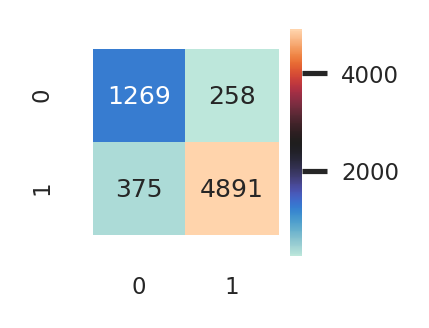

In [83]:
plt.figure(figsize=(1,1),dpi=300)
sns.set(font_scale=0.5)
sns.heatmap(confusion_matrix(y_test,prediction),fmt="g",square=True,annot = True,cmap = 'icefire')

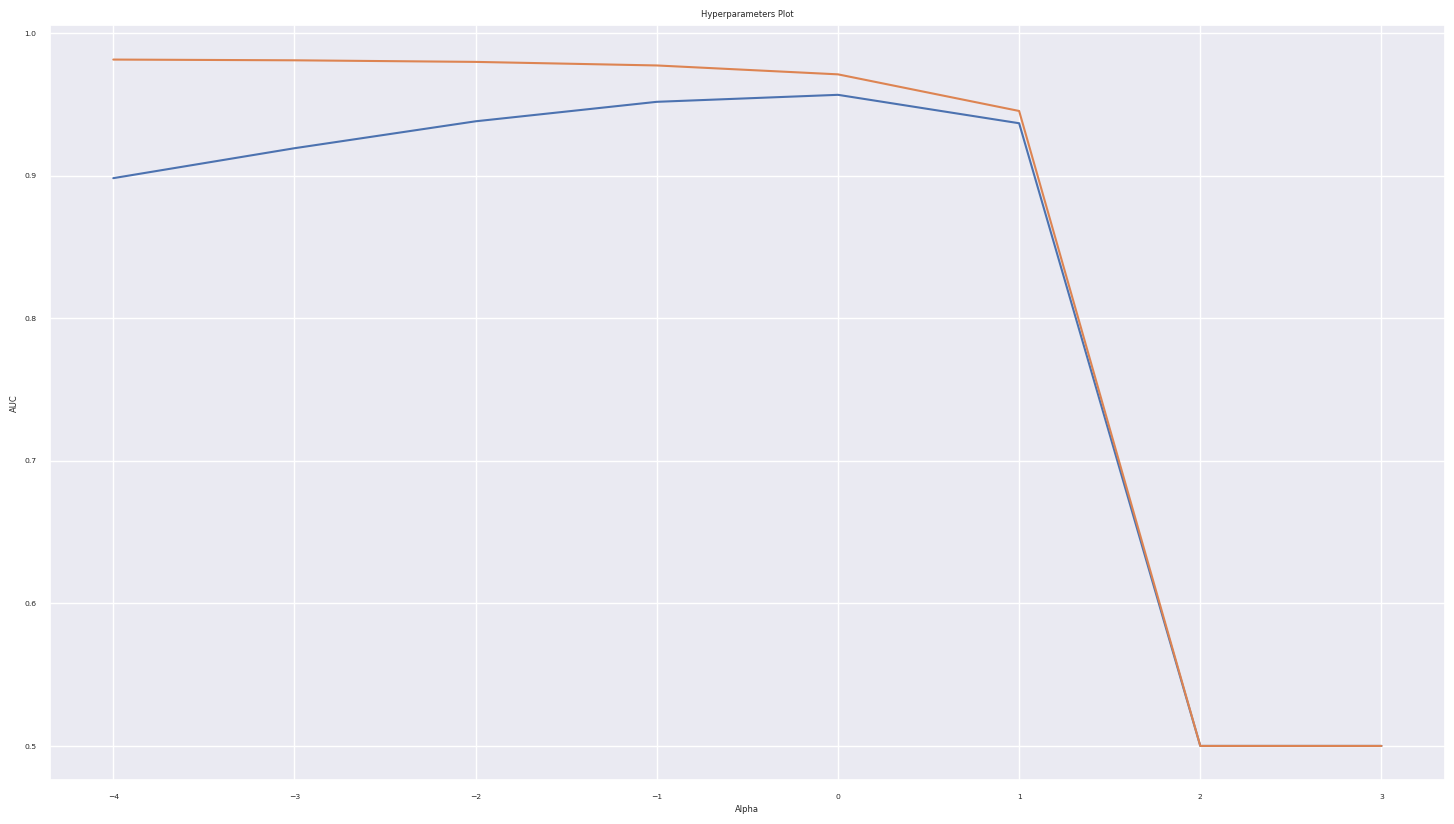

In [84]:
import math
plt.figure(figsize=(18,10),dpi=100)
plt.plot(np.log10(C),df_nb['mean_test_score'],label="Validation AUC")
plt.plot(np.log10(C),df_nb['mean_train_score'],label="Train AUC")
plt.ylabel('AUC')
plt.xlabel('Alpha')
plt.title('Hyperparameters Plot')
plt.show()

## Logistic Regression

In [85]:
from sklearn.linear_model import LogisticRegression
lr = GridSearchCV(LogisticRegression(),param_grid={"max_iter":[1000,1500]},scoring='roc_auc',cv=5)
lr.fit(x_train,y_train)
df_lr = lr.cv_results_
df_lr = pd.DataFrame(df_lr)
df_lr 

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       5.054117      0.852325         0.022089        0.000052   
1       4.992956      0.834555         0.022142        0.000238   

  param_max_iter              params  split0_test_score  split1_test_score  \
0           1000  {'max_iter': 1000}           0.959834           0.956661   
1           1500  {'max_iter': 1500}           0.959834           0.956661   

   split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
0            0.96553           0.958209           0.964618          0.96097   
1            0.96553           0.958209           0.964618          0.96097   

   std_test_score  rank_test_score  
0        0.003509                1  
1        0.003509                1

In [86]:
prediction = lr.predict(x_test)
print(accuracy_score(prediction,y_test))

0.9341969674665096


## SGD Classifier

In [87]:
from sklearn.linear_model import SGDClassifier
svm = GridSearchCV(SGDClassifier(loss='hinge',penalty='l2'),{'alpha':[0.001,0.01]},scoring='roc_auc',cv=5)
svm.fit(x_train,y_train)
df_svm = svm.cv_results_
df_svm = pd.DataFrame(df_svm)
df_svm 

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       1.430097      0.130359         0.023843        0.003769       0.001   
1       1.106624      0.079244         0.023170        0.003854        0.01   

             params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.001}           0.954461           0.953651           0.957085   
1   {'alpha': 0.01}           0.956901           0.956609           0.963585   

   split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0           0.953116           0.955681         0.954799        0.001433   
1           0.957247           0.960602         0.958989        0.002713   

   rank_test_score  
0                2  
1                1

In [88]:
prediction = svm.predict(x_test)
print(accuracy_score(prediction,y_test))

0.933313705284852
